In [1]:
#importing libraries
import yaml
from utils import *
import streaming_goldreich as streaming_goldreich
#from itertools import product
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#Reproducibility
from utils import init_seed
init_seed(0)
n_iterations = 10

In [2]:
df = pd.read_csv("compas_arrest_processed.csv")

for column in df.columns[1:]:
    df[column] = (df[column]).astype(int)
    df[column]= np.where(df[column] == 0, -1, df[column])

columns_delete = [ 'n_juvenile_misdemeanors_eq_0', 'n_juvenile_misdemeanors_geq_1', 
                  'n_juvenile_misdemeanors_geq_2', 'n_juvenile_misdemeanors_geq_5', 'n_juvenile_felonies_eq_0', 
                  'n_juvenile_felonies_geq_1', 'n_juvenile_felonies_geq_2', 'n_juvenile_felonies_geq_5']
df = df.drop(columns_delete, axis=1)

def load_compas():
    y = np.array(df["arrest"] == 1, dtype=bool)   
    a = np.array(df["race_is_causasian"])
    X = df.to_numpy().astype('float')[:, 1:] #get rid off label
    return X, y, a

X, y, a= load_compas()


In [3]:
h_star = LogisticRegression(penalty='l2', random_state=1, 
                              max_iter=5000).fit(X, y)

h_star.score(X, y)


0.6707712248865846

In [4]:
y = h_star.predict(X)
X_a1 = X[a == 1]
X_a0 = X[a == -1]
(X_a1.shape, X_a0.shape)

((2103, 13), (4069, 13))

# Experiments for rho

## Experiment 1

In [5]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 1"
target_experiment = experiment_dict.get(target_experiment_name)

In [6]:
if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    p = (1 + rho) / 2
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp

In [7]:

def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.882372

In [8]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.8413804

### Basline: I.I.D Estimator

In [9]:
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 


### AFA (Ours)

In [10]:

class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate

In [11]:

AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [12]:
IID_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]  

for idx,experiment in enumerate(IID_experiments):
    for i in range(n_iterations):
        experiment[i].append([iid_rb((idx+1)*100,rho), iid_if((idx+1)*100,rho,l)])

In [13]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [14]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [15]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)


In [16]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.818812,0.035866,0.752475,0.816832,0.871287
2,10.0,0.813930,0.032514,0.766169,0.808458,0.875622
3,10.0,0.814950,0.022317,0.767442,0.817276,0.840532
4,10.0,0.800000,0.018691,0.775561,0.799252,0.837905
5,10.0,0.811577,0.019288,0.782435,0.810379,0.844311
6,10.0,0.815141,0.014302,0.787022,0.821131,0.830283
7,10.0,0.816120,0.017071,0.783167,0.819544,0.833096
8,10.0,0.814232,0.006958,0.802747,0.812734,0.826467
9,10.0,0.815205,0.006985,0.805771,0.814095,0.826859


In [17]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.890099,0.022602,0.861386,0.886139,0.930693
2,10.0,0.900995,0.020773,0.870647,0.900498,0.925373
3,10.0,0.891694,0.015987,0.863787,0.892027,0.923588
4,10.0,0.882544,0.014515,0.865337,0.877805,0.905237
5,10.0,0.890818,0.014147,0.874251,0.886228,0.914172
6,10.0,0.897837,0.013590,0.876872,0.900998,0.916805
7,10.0,0.894437,0.008453,0.874465,0.897290,0.902996
8,10.0,0.890637,0.011339,0.876405,0.887640,0.917603
9,10.0,0.892564,0.011182,0.880133,0.889567,0.916759


In [18]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.269000,0.145560,0.070000,0.270000,0.570000
2,10.0,0.244000,0.165928,-0.130000,0.290000,0.480000
3,10.0,0.265000,0.152738,0.066667,0.230000,0.660000
4,10.0,0.304750,0.090810,0.180000,0.290000,0.470000
5,10.0,0.281000,0.107820,0.102000,0.258000,0.492000
6,10.0,0.295500,0.111361,0.171667,0.295000,0.515000
7,10.0,0.263571,0.114805,0.024286,0.299286,0.384286
8,10.0,0.220250,0.060739,0.115000,0.214375,0.307500
9,10.0,0.267778,0.094748,0.102222,0.304444,0.367778


In [19]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.044000,0.121216,-0.140000,0.065000,0.200000
2,10.0,0.164000,0.083659,0.010000,0.157500,0.280000
3,10.0,0.099333,0.091163,-0.070000,0.110000,0.276667
4,10.0,0.064250,0.094788,-0.077500,0.048750,0.242500
5,10.0,0.077400,0.096853,-0.120000,0.077000,0.208000
6,10.0,0.067333,0.104389,-0.073333,0.063333,0.301667
7,10.0,0.105571,0.047473,0.025714,0.115000,0.162857
8,10.0,0.060625,0.071730,-0.073750,0.071875,0.156250
9,10.0,0.068000,0.064839,-0.082222,0.083889,0.156667


In [20]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


random estimator average error for robustness: [0.0188119, 0.023313105, 0.014098382, 0.012219453, 0.012148345, 0.01733219, 0.013645887, 0.00945819, 0.010643375, 0.015931433]
random estimator average error for individual fairness: [0.030652314, 0.038161587, 0.02643025, 0.041380417, 0.030389767, 0.026238997, 0.025260597, 0.027148198, 0.026175093, 0.018603195]
AFA average error for robustness: [0.8383720216751099, 0.7183720216751098, 0.7830386883417765, 0.8181220216751098, 0.80497202167511, 0.8150386883417765, 0.7768005931036813, 0.8217470216751097, 0.8143720216751099, 0.8236720216751099]
AFA average error for individual fairness: [0.5723804173469542, 0.5973804173469544, 0.5763804173469543, 0.5366304173469544, 0.5603804173469543, 0.5458804173469544, 0.5778089887755258, 0.6211304173469543, 0.5736026395691766, 0.5209804173469543]


In [21]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

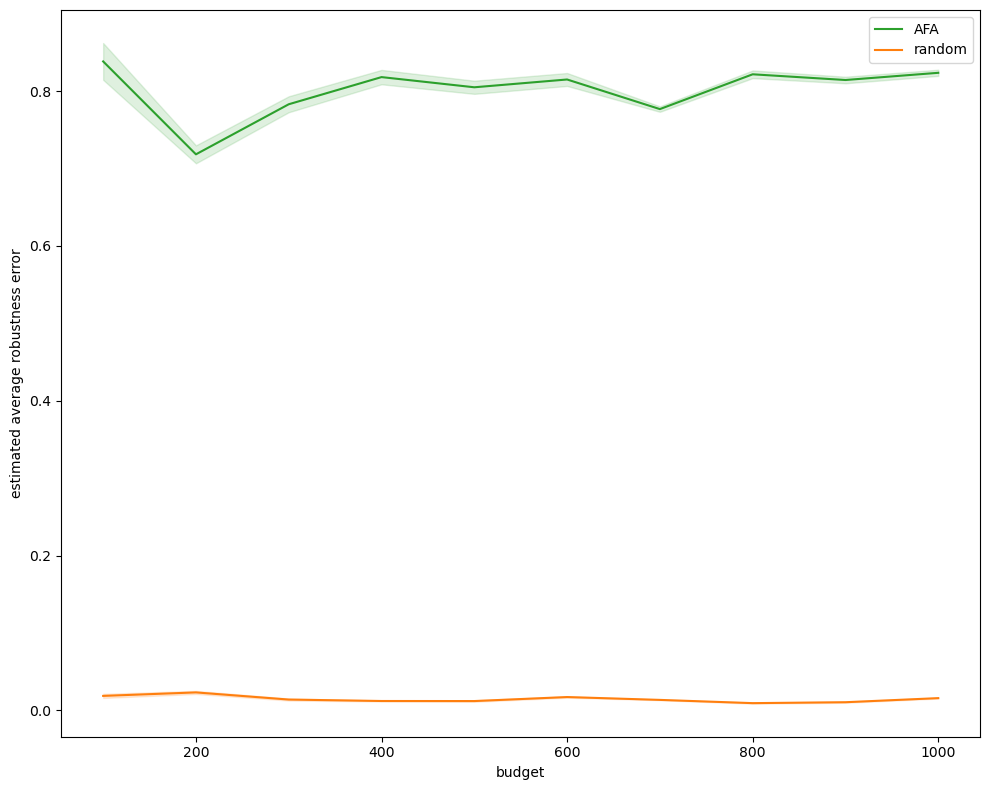

In [22]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

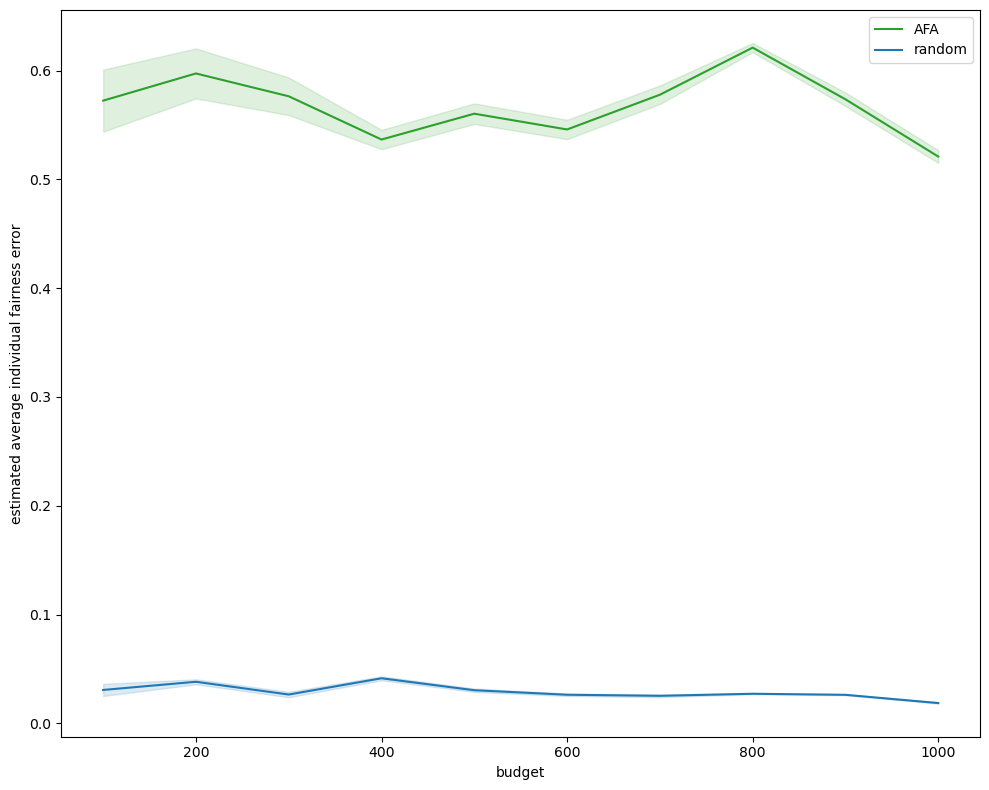

In [23]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 2

In [24]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 2"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [25]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.69021386

In [26]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.6647764

In [27]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [28]:
#baseline 
IID_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]  

for idx,experiment in enumerate(IID_experiments):
    for i in range(n_iterations):
        experiment[i].append([iid_rb((idx+1)*100,rho), iid_if((idx+1)*100,rho,l)])

In [29]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [30]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [31]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [32]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [33]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [34]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [35]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.200186,0.050501,0.145000,0.184912,0.316250
2,10.0,0.197727,0.045750,0.132500,0.207988,0.260547
3,10.0,0.241033,0.036461,0.197917,0.237109,0.302806
4,10.0,0.188562,0.051507,0.090121,0.196973,0.249063
5,10.0,0.208132,0.038106,0.137001,0.224476,0.242238
6,10.0,0.197528,0.047069,0.133509,0.203568,0.281704
7,10.0,0.228013,0.043592,0.174604,0.222825,0.292554
8,10.0,0.251603,0.035902,0.190334,0.260925,0.302871
9,10.0,0.236380,0.041481,0.157342,0.235608,0.296070


In [36]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.172301,0.027312,0.128047,0.167500,0.224219
2,10.0,0.146179,0.034467,0.073047,0.157344,0.200625
3,10.0,0.147479,0.030115,0.100833,0.154958,0.179167
4,10.0,0.138515,0.030818,0.100723,0.131143,0.189375
5,10.0,0.155761,0.025508,0.112898,0.155898,0.196949
6,10.0,0.137766,0.025486,0.084251,0.141536,0.171198
7,10.0,0.140974,0.023225,0.099621,0.140502,0.172567
8,10.0,0.133840,0.016660,0.111309,0.135430,0.158311
9,10.0,0.138870,0.019099,0.108811,0.141719,0.165647


In [37]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.037623774, 0.037047744, 0.030244177, 0.026734674, 0.02211235, 0.027273083, 0.03562329, 0.014183891, 0.019429684, 0.021202052]
random estimator average error for individual fairness: [0.03747969, 0.032199156, 0.037801176, 0.031072985, 0.0170295, 0.028160548, 0.032677032, 0.021712279, 0.02948227, 0.019645046]
AFA average error for robustness: [0.5179130778312683, 0.5440351481437683, 0.5427353434562684, 0.5516992106437684, 0.5344525309562683, 0.5524482340812684, 0.5492395287241255, 0.5563740153312683, 0.5513438504007127, 0.5450917887687683]
AFA average error for individual fairness: [0.4645908379554749, 0.46704933404922483, 0.4237433444658915, 0.47621424961090086, 0.4566440728187562, 0.4672481865882873, 0.43676385954448155, 0.41317364740371704, 0.42839639351103037, 0.44291277093887327]


In [38]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

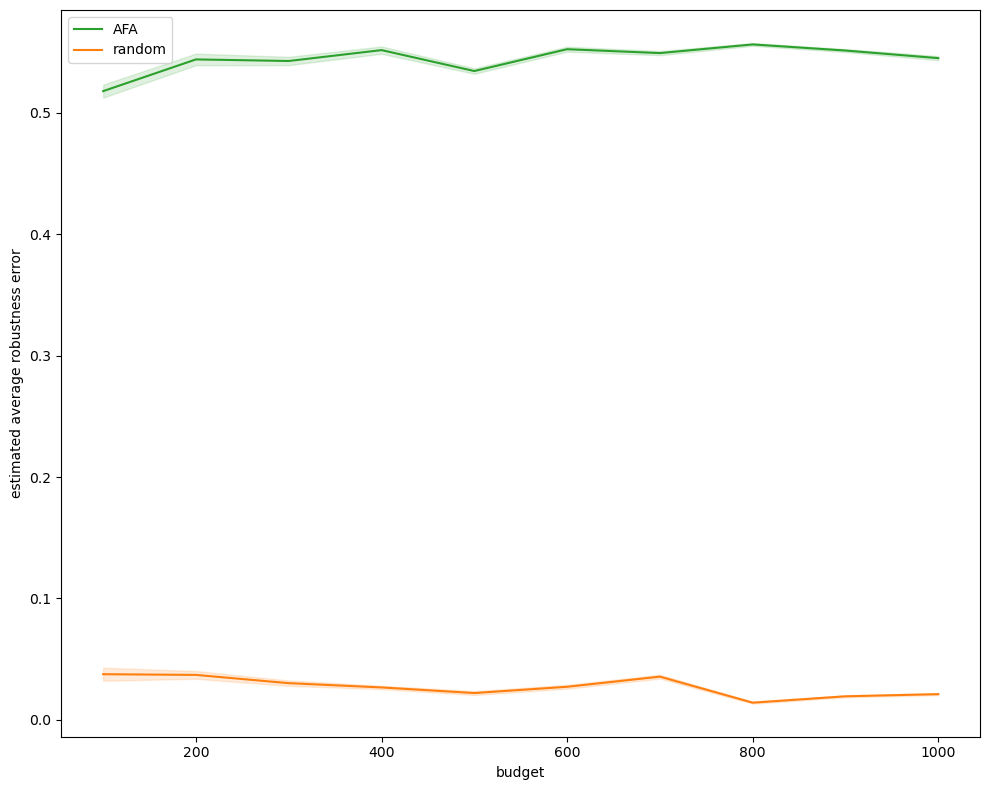

In [39]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

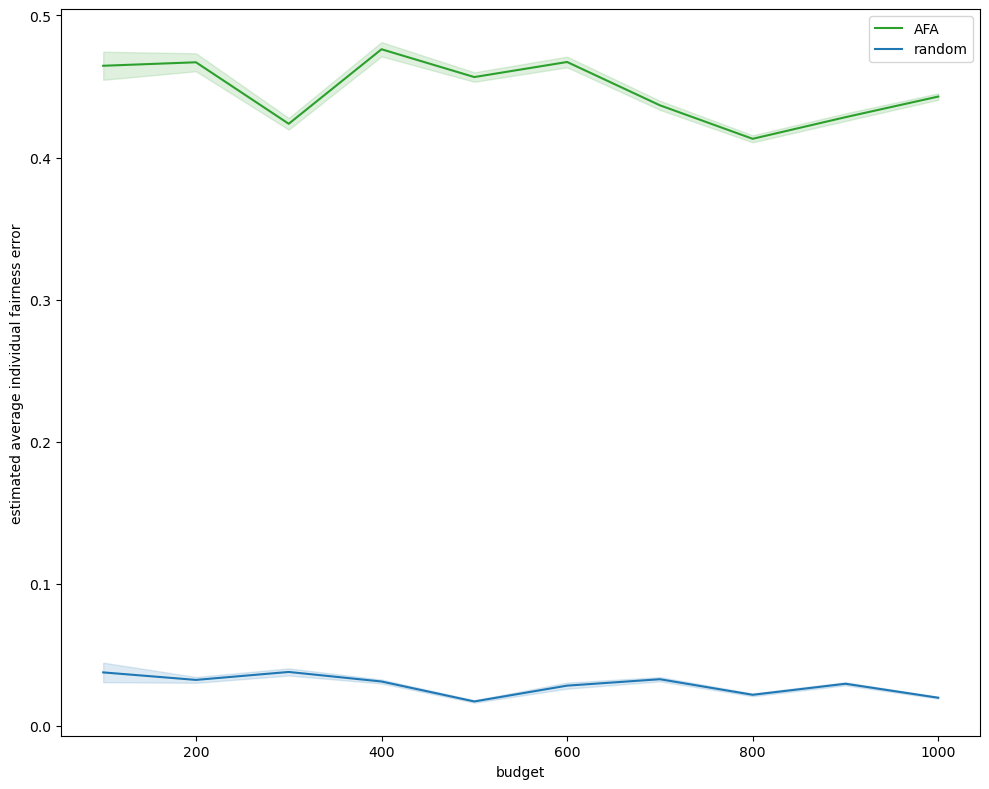

In [40]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 3

In [41]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 3"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [42]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.5814971

In [43]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.56788725

In [44]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [45]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 

class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [46]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [47]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [48]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [49]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [50]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [51]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [52]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.231821,0.060417,0.155000,0.221188,0.361543
2,10.0,0.216279,0.043874,0.154356,0.203232,0.302982
3,10.0,0.209252,0.056994,0.151038,0.191769,0.344635
4,10.0,0.203069,0.021631,0.169384,0.204224,0.244687
5,10.0,0.231461,0.057488,0.181668,0.201755,0.331591
6,10.0,0.221843,0.036847,0.188294,0.209640,0.307541
7,10.0,0.236104,0.040070,0.169772,0.240908,0.299767
8,10.0,0.231481,0.057840,0.165353,0.217340,0.325354
9,10.0,0.228072,0.033727,0.197485,0.215356,0.295560


In [53]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.187005,0.063965,0.103162,0.180399,0.293581
2,10.0,0.186005,0.039576,0.113208,0.185744,0.244051
3,10.0,0.184518,0.022070,0.143352,0.182785,0.215603
4,10.0,0.154726,0.018465,0.127358,0.155836,0.193320
5,10.0,0.165975,0.014758,0.145380,0.170285,0.189553
6,10.0,0.179566,0.023281,0.134941,0.180506,0.216230
7,10.0,0.161087,0.020197,0.135245,0.159966,0.198747
8,10.0,0.172019,0.015505,0.134822,0.175758,0.188562
9,10.0,0.173244,0.018933,0.146494,0.172301,0.206586


In [54]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.105631635, 0.08566711, 0.083286986, 0.08558522, 0.08916162, 0.084559485, 0.07313917, 0.09453289, 0.089313135, 0.0895319]
random estimator average error for individual fairness: [0.07341296, 0.068431176, 0.06035195, 0.06652671, 0.08580537, 0.06888479, 0.06478037, 0.07643235, 0.06740687, 0.078666195]
AFA average error for robustness: [0.3944916868209839, 0.39549171304702757, 0.39697878185908003, 0.4267708225250244, 0.4155217046737671, 0.4019310464859009, 0.42041045120784215, 0.4094780321121216, 0.40825334135691327, 0.4165230096101761]
AFA average error for individual fairness: [0.3360658881664276, 0.35160813620686526, 0.3586352424621583, 0.36481825113319793, 0.33642627754183485, 0.3460443820239355, 0.33178363087720103, 0.3364064895194024, 0.3398153510768769, 0.323305247713346]


In [55]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

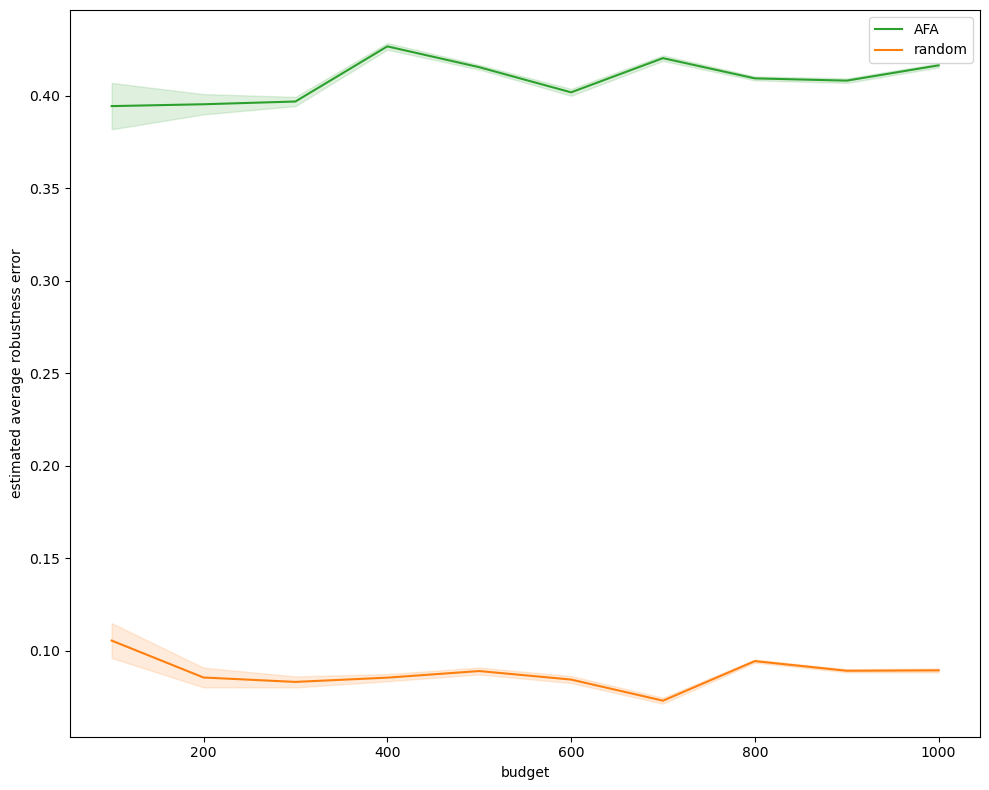

In [56]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

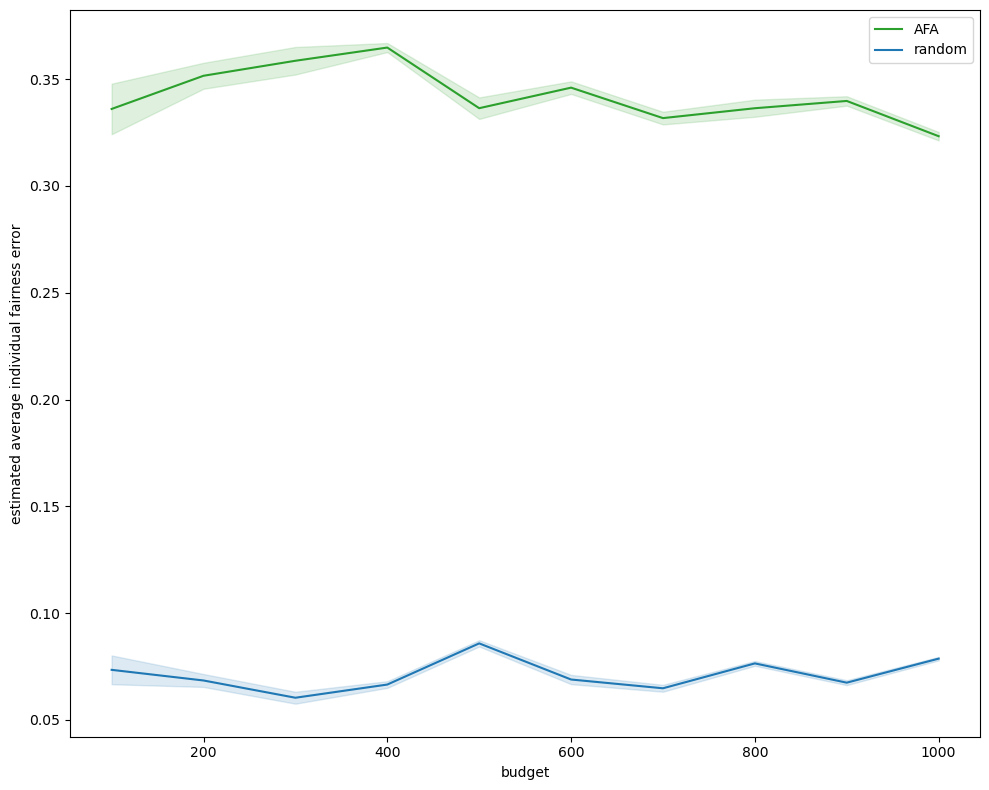

In [57]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 4

In [58]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 4"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [59]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.4405379

In [60]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.4682437

In [61]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [62]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [63]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [64]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [65]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [66]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [67]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [68]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [69]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.194928,0.025549,0.148007,0.196480,0.239810
2,10.0,0.249933,0.056007,0.166255,0.239784,0.341347
3,10.0,0.238098,0.049481,0.153166,0.247532,0.303003
4,10.0,0.238298,0.035611,0.148575,0.246363,0.275340
5,10.0,0.257877,0.056271,0.173655,0.266980,0.351638
6,10.0,0.257149,0.053374,0.194829,0.246366,0.348189
7,10.0,0.262180,0.049709,0.190688,0.255399,0.338540
8,10.0,0.250850,0.056992,0.187702,0.236423,0.344923
9,10.0,0.249114,0.044329,0.181784,0.261716,0.305657


In [70]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.200806,0.044358,0.121951,0.197045,0.291114
2,10.0,0.199801,0.025631,0.156205,0.200142,0.239036
3,10.0,0.204118,0.014562,0.176009,0.203938,0.227223
4,10.0,0.219218,0.018204,0.197079,0.214327,0.257717
5,10.0,0.214429,0.026521,0.178726,0.213079,0.266330
6,10.0,0.216582,0.012091,0.196300,0.217624,0.237029
7,10.0,0.211853,0.019081,0.182789,0.211926,0.244072
8,10.0,0.215254,0.017260,0.189787,0.212556,0.245357
9,10.0,0.210526,0.009845,0.198993,0.209319,0.226792


In [71]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.24659081, 0.22662628, 0.22424617, 0.22654441, 0.23012081, 0.22551867, 0.21409833, 0.23549207, 0.23027232, 0.23049107]
random estimator average error for individual fairness: [0.16838996, 0.16807474, 0.15999551, 0.16617027, 0.18544893, 0.16852835, 0.16442393, 0.1760759, 0.16705042, 0.17830977]
AFA average error for robustness: [0.23973205274858972, 0.24073738760808974, 0.23641947512942973, 0.2213200287524572, 0.22610901488840973, 0.22395615069942304, 0.22868522172443115, 0.22528342223258974, 0.23001157454338972, 0.2328092299243897]
AFA average error for individual fairness: [0.27331607202895547, 0.2183110214444579, 0.23014519130978878, 0.22994601999745545, 0.21036688641855544, 0.21109474560933875, 0.2060635949597597, 0.21739329070358043, 0.21913000278254544, 0.20448374480992476]


In [72]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

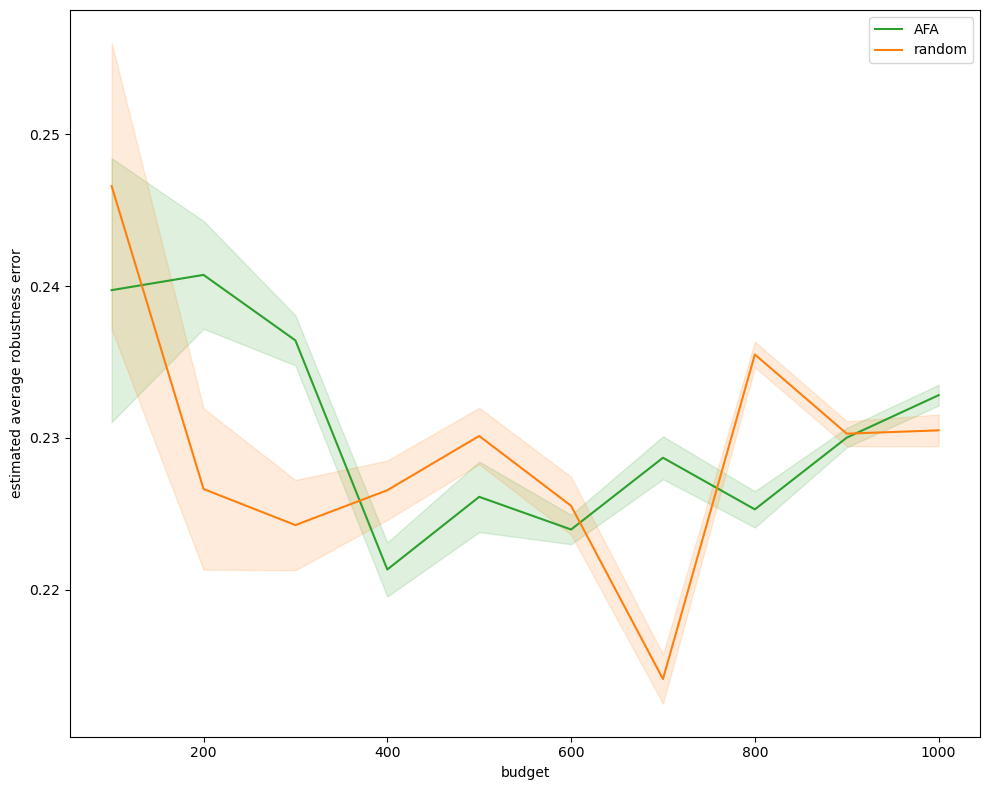

In [73]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

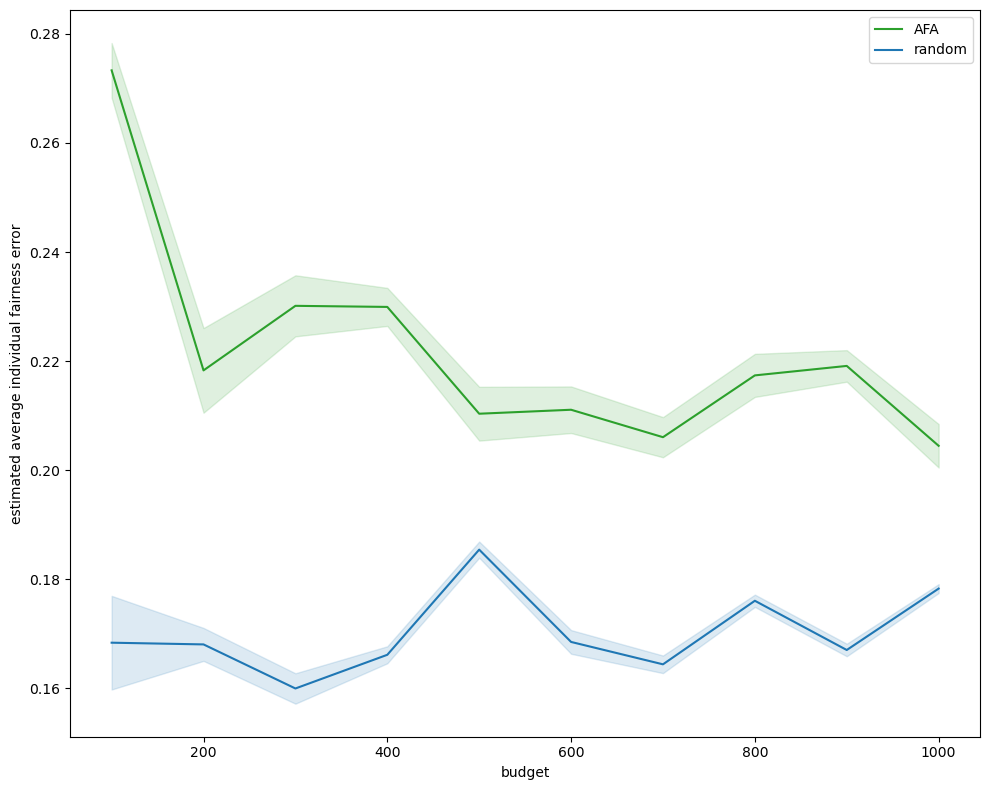

In [74]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 5

In [75]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 5"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [76]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.37151653

In [77]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.3984122

In [78]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [79]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [80]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [81]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [82]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [83]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [84]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [85]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [86]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.245908,0.082478,0.125310,0.248140,0.364997
2,10.0,0.235934,0.056152,0.150080,0.226868,0.332615
3,10.0,0.260441,0.048807,0.209544,0.242358,0.341394
4,10.0,0.250164,0.066724,0.129888,0.240603,0.355347
5,10.0,0.278366,0.071760,0.166232,0.268691,0.404469
6,10.0,0.279143,0.045805,0.231024,0.263007,0.365976
7,10.0,0.265340,0.036500,0.208142,0.265354,0.317357
8,10.0,0.285562,0.041282,0.206857,0.298608,0.329781
9,10.0,0.280497,0.031702,0.237066,0.278982,0.348275


In [87]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.222130,0.041692,0.141312,0.233040,0.269192
2,10.0,0.212319,0.018543,0.174515,0.210634,0.237292
3,10.0,0.225289,0.023599,0.191816,0.220273,0.273345
4,10.0,0.218872,0.028285,0.167616,0.220275,0.264898
5,10.0,0.229230,0.020297,0.203314,0.223360,0.275329
6,10.0,0.243142,0.020631,0.207875,0.250002,0.274825
7,10.0,0.240029,0.012297,0.222303,0.239173,0.259302
8,10.0,0.237357,0.018513,0.210244,0.236423,0.270400
9,10.0,0.227436,0.015628,0.204561,0.230310,0.249472


In [88]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.3156122, 0.29564768, 0.29326755, 0.29556578, 0.29914218, 0.29454002, 0.2831197, 0.30451345, 0.2992937, 0.29951245]
random estimator average error for individual fairness: [0.23822144, 0.23790625, 0.229827, 0.23600176, 0.25528044, 0.23835984, 0.2342554, 0.24590738, 0.23688193, 0.24814124]
AFA average error for robustness: [0.14938679974539187, 0.15919786123039184, 0.14622797910495855, 0.15264461038171687, 0.14228684714959186, 0.12837423590237515, 0.13148736345891754, 0.13415937331589184, 0.1440807655690585, 0.13958845145098187]
AFA average error for individual fairness: [0.15250384143339285, 0.16247817498829284, 0.13797123543858308, 0.14824794158514285, 0.12125787009263427, 0.11926932487161541, 0.13307211163949284, 0.11285000577186659, 0.1179154708630483, 0.09227702579816596]


In [89]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

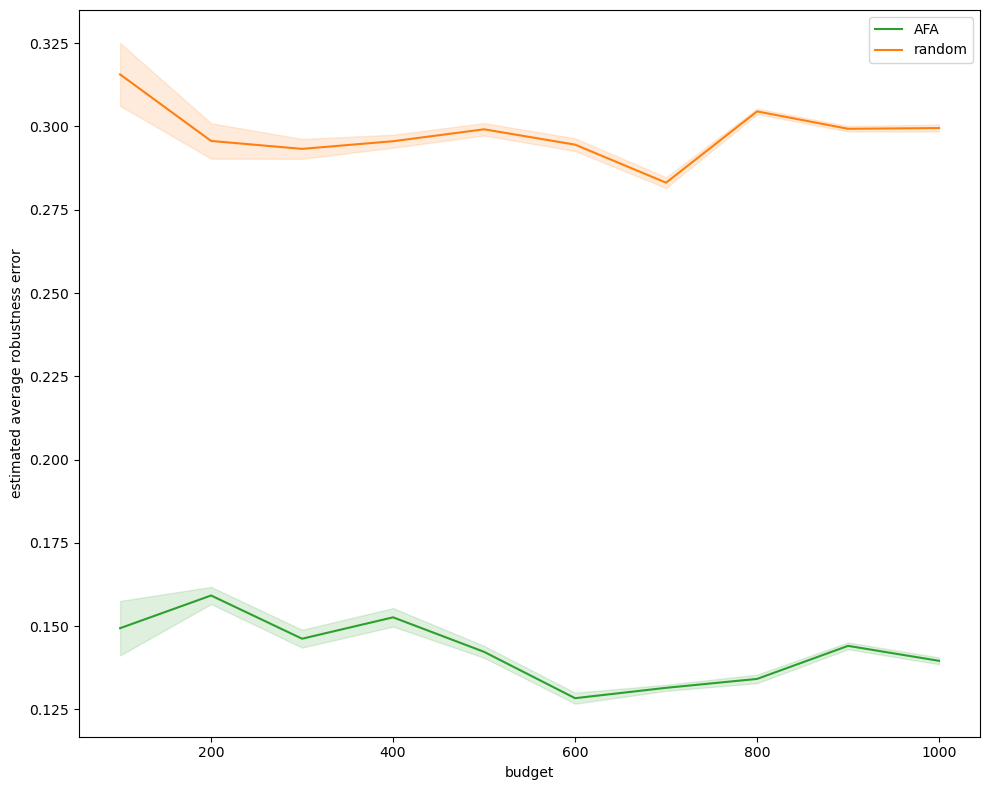

In [90]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

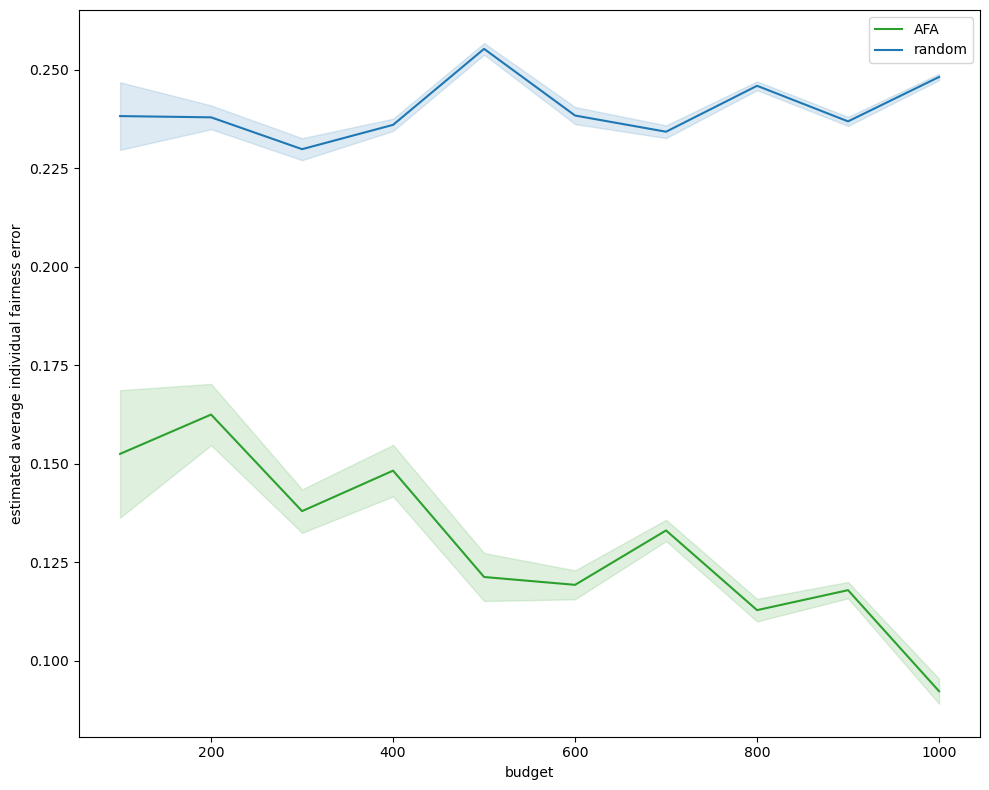

In [91]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 6

In [92]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 6"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [93]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.36179522

In [94]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.37313676

In [95]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [96]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [97]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [98]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [99]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [100]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [101]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [102]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [103]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.234631,0.081905,0.110000,0.264507,0.362751
2,10.0,0.241613,0.055213,0.190270,0.220914,0.358601
3,10.0,0.253294,0.037688,0.210476,0.245127,0.318074
4,10.0,0.270301,0.073420,0.174905,0.246332,0.414004
5,10.0,0.282480,0.058470,0.211142,0.278543,0.407098
6,10.0,0.293038,0.068372,0.158706,0.297542,0.364722
7,10.0,0.284325,0.040953,0.239284,0.282424,0.356818
8,10.0,0.271065,0.033905,0.229685,0.273844,0.333243
9,10.0,0.277700,0.046623,0.205313,0.277805,0.371634


In [104]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.216105,0.067812,0.088521,0.217709,0.320036
2,10.0,0.203336,0.040766,0.118073,0.203337,0.255730
3,10.0,0.253208,0.032381,0.214376,0.244228,0.314788
4,10.0,0.237552,0.021029,0.215763,0.233017,0.272462
5,10.0,0.239503,0.026986,0.202543,0.238989,0.281547
6,10.0,0.235286,0.017699,0.209708,0.233237,0.260455
7,10.0,0.250575,0.013199,0.230164,0.253671,0.275679
8,10.0,0.230933,0.015746,0.204843,0.229550,0.261467
9,10.0,0.241891,0.017783,0.211280,0.245150,0.269643


In [105]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.3253335, 0.30536896, 0.30298883, 0.30528706, 0.3088635, 0.30426136, 0.29284102, 0.31423476, 0.309015, 0.30923375]
random estimator average error for individual fairness: [0.2634969, 0.26318163, 0.25510243, 0.2612772, 0.28055584, 0.26363525, 0.25953084, 0.27118284, 0.26215735, 0.2734167]
AFA average error for robustness: [0.1456905757014386, 0.15845881030902356, 0.10858756955659485, 0.1242428060080206, 0.12229235668819101, 0.12650879281816588, 0.11122035179486855, 0.1308621570704504, 0.11990411150702736, 0.11245428912541515]
AFA average error for individual fairness: [0.13850586017446925, 0.13152409043612398, 0.11984242064926309, 0.11100890990097997, 0.09744941821788669, 0.08009860076529686, 0.08881205718762486, 0.10207206375063474, 0.09543667105487827, 0.08615939198876343]


In [106]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

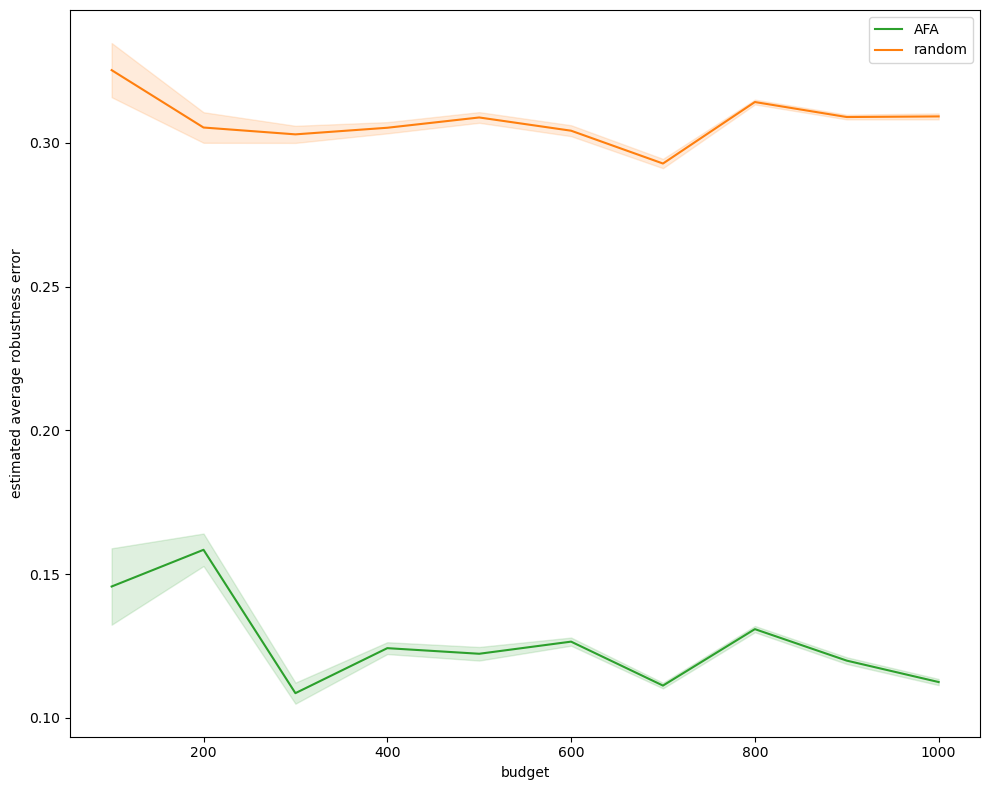

In [107]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

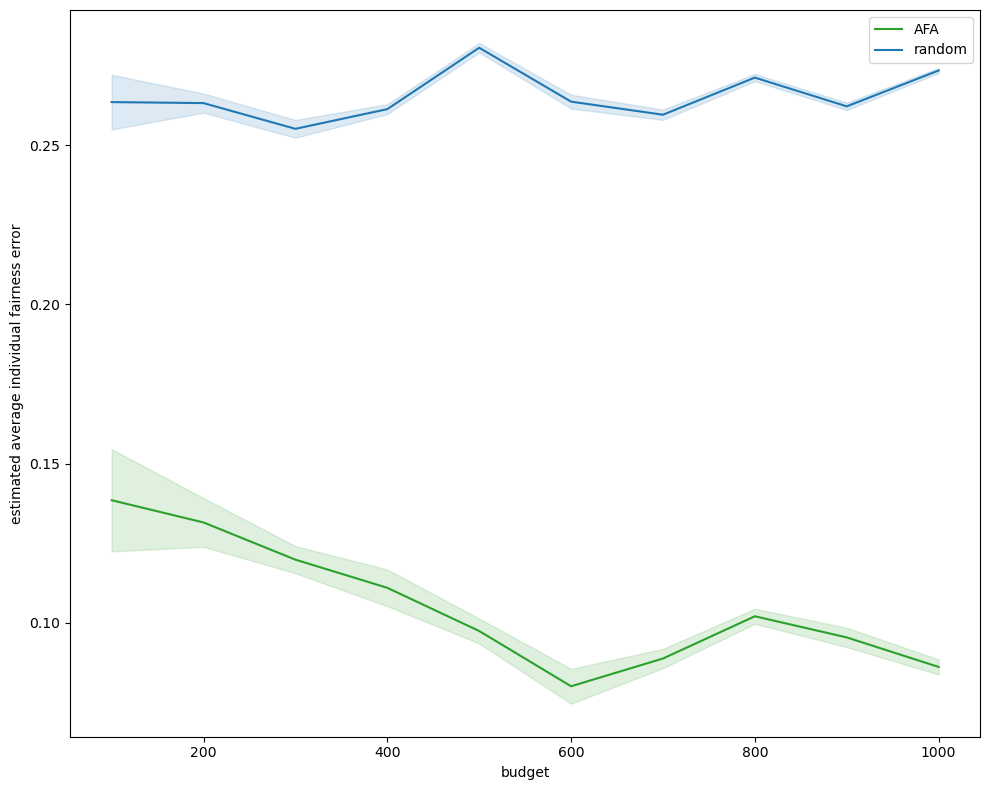

In [108]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 7

In [109]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for rho']}
target_experiment_name = "Experiment 7"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [110]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.35628647

In [111]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.37686324

In [112]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [113]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [114]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [115]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [116]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [117]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [118]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [119]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [120]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.203537,0.063399,0.117942,0.202243,0.302853
2,10.0,0.232441,0.089270,0.079782,0.210559,0.397165
3,10.0,0.274819,0.068830,0.166602,0.283804,0.394724
4,10.0,0.276648,0.054152,0.200698,0.273594,0.354960
5,10.0,0.278969,0.049660,0.211661,0.274555,0.399355
6,10.0,0.290669,0.050349,0.220182,0.292146,0.364271
7,10.0,0.265158,0.026693,0.218846,0.260037,0.318026
8,10.0,0.267393,0.054498,0.180571,0.278420,0.374101
9,10.0,0.296190,0.049486,0.207897,0.298378,0.363696


In [121]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.220166,0.044184,0.141434,0.226052,0.295000
2,10.0,0.213916,0.029555,0.154971,0.213640,0.266512
3,10.0,0.234432,0.036531,0.183641,0.244652,0.295618
4,10.0,0.227709,0.034751,0.172100,0.228966,0.281844
5,10.0,0.245519,0.018705,0.200147,0.252071,0.260225
6,10.0,0.243876,0.023889,0.208907,0.238753,0.288696
7,10.0,0.241749,0.024193,0.202695,0.237395,0.296824
8,10.0,0.240042,0.021583,0.201332,0.241386,0.273014
9,10.0,0.242941,0.016395,0.225217,0.238616,0.279180


In [122]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.33084223, 0.31087774, 0.3084976, 0.31079584, 0.31437224, 0.30977008, 0.2983498, 0.31974348, 0.31452376, 0.3147425]
random estimator average error for individual fairness: [0.2597704, 0.25945514, 0.25137594, 0.25755072, 0.27682936, 0.25990877, 0.25580436, 0.26745635, 0.25843087, 0.26969022]
AFA average error for robustness: [0.13612049844347437, 0.1423705892939392, 0.1218541489840758, 0.1285776891935222, 0.11076761250444625, 0.11241060170977057, 0.11453709063211445, 0.116244632511545, 0.11334540704626968, 0.1035994358730105]
AFA average error for individual fairness: [0.17332651094567872, 0.14848233867480568, 0.10561608598672681, 0.10021570961206874, 0.10239233124665885, 0.08619433913472631, 0.11170551729561089, 0.1094702965900046, 0.08067322796817632, 0.09207064388182577]


In [123]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

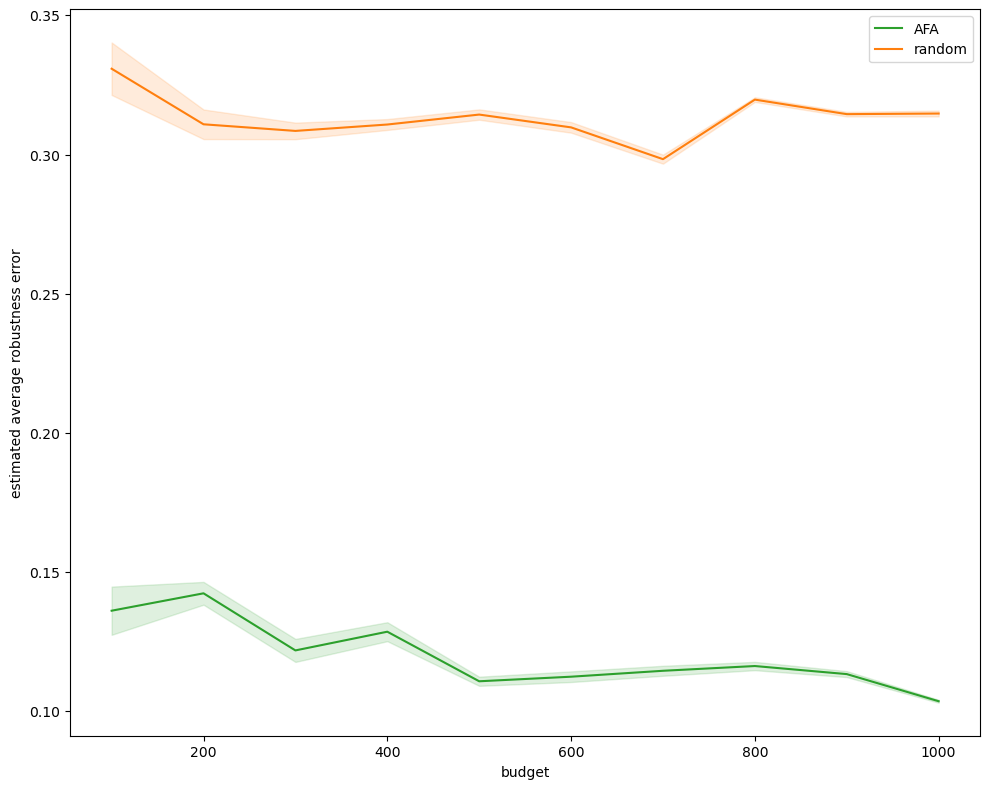

In [124]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

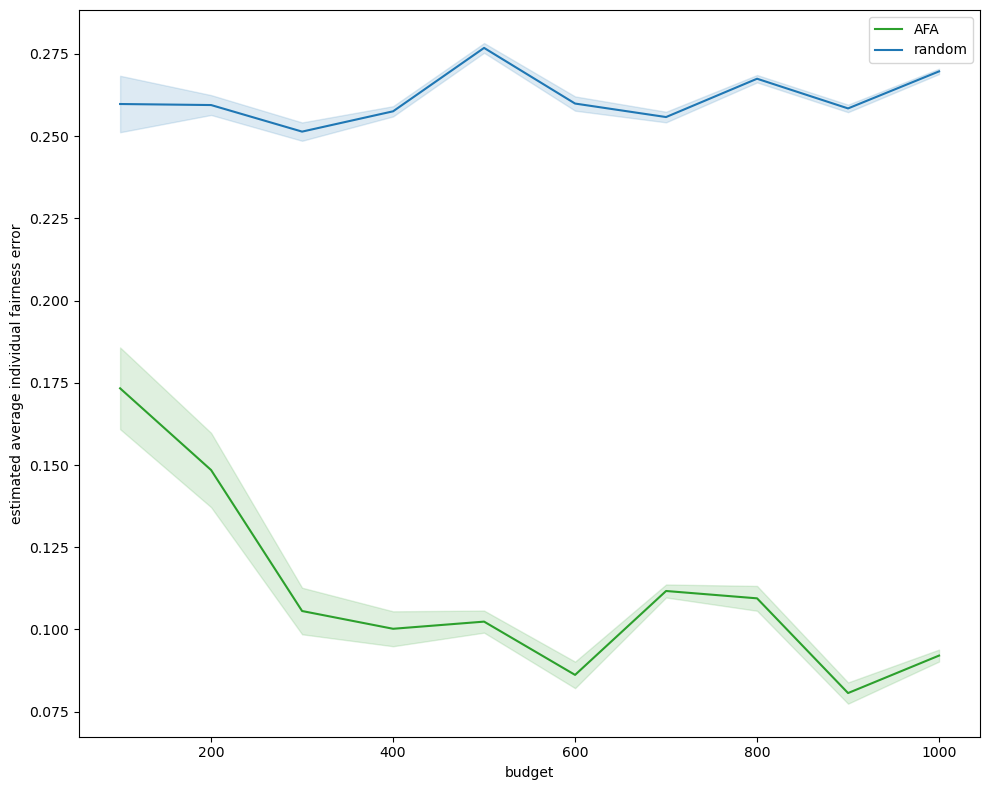

In [125]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

# Experiments for l

## Experiment 1

In [126]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 1"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [127]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.21241088

In [128]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.23784834

In [129]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [130]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [131]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [132]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [133]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [134]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [135]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [136]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [137]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.290198,0.135086,0.052256,0.271890,0.494400
2,10.0,0.242921,0.093831,0.014139,0.284043,0.316335
3,10.0,0.245777,0.092137,0.060887,0.271312,0.352843
4,10.0,0.282117,0.057741,0.168772,0.276535,0.355710
5,10.0,0.296446,0.061241,0.195476,0.311162,0.385100
6,10.0,0.287541,0.063611,0.195208,0.286903,0.390067
7,10.0,0.303533,0.079257,0.195892,0.302184,0.463590
8,10.0,0.302841,0.075524,0.201216,0.300503,0.404313
9,10.0,0.302140,0.061680,0.230641,0.283064,0.412989


In [138]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.270130,0.063132,0.186350,0.270826,0.349953
2,10.0,0.239197,0.048063,0.149128,0.250469,0.299340
3,10.0,0.260815,0.040802,0.188817,0.253159,0.313828
4,10.0,0.310660,0.024258,0.277375,0.310309,0.352905
5,10.0,0.297312,0.020190,0.272956,0.296126,0.324807
6,10.0,0.274462,0.038485,0.195902,0.280266,0.323927
7,10.0,0.276301,0.035775,0.230666,0.282214,0.342397
8,10.0,0.296647,0.026973,0.269963,0.288211,0.359877
9,10.0,0.300340,0.016506,0.271983,0.303317,0.317017


In [139]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.47471786, 0.45475334, 0.45237318, 0.45467144, 0.45824784, 0.4536457, 0.44222537, 0.46361914, 0.4583993, 0.4586181]
random estimator average error for individual fairness: [0.39878532, 0.39847007, 0.39039084, 0.39656562, 0.41584426, 0.3989237, 0.39481926, 0.40647125, 0.39744577, 0.4087051]
AFA average error for robustness: [0.06740260826335157, 0.04632860749885438, 0.053122667174375415, 0.09824919165601093, 0.08490086678423595, 0.0653526114618271, 0.06389027715129163, 0.08423592271216092, 0.08792932647463592, 0.07854657756253589]
AFA average error for individual fairness: [0.10438209512100223, 0.07232401681400144, 0.0716133407473348, 0.058838305109502186, 0.0750825491210022, 0.06177372033066812, 0.08103688092100218, 0.0796349942960022, 0.06573316542800292, 0.09183186235100296]


In [140]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

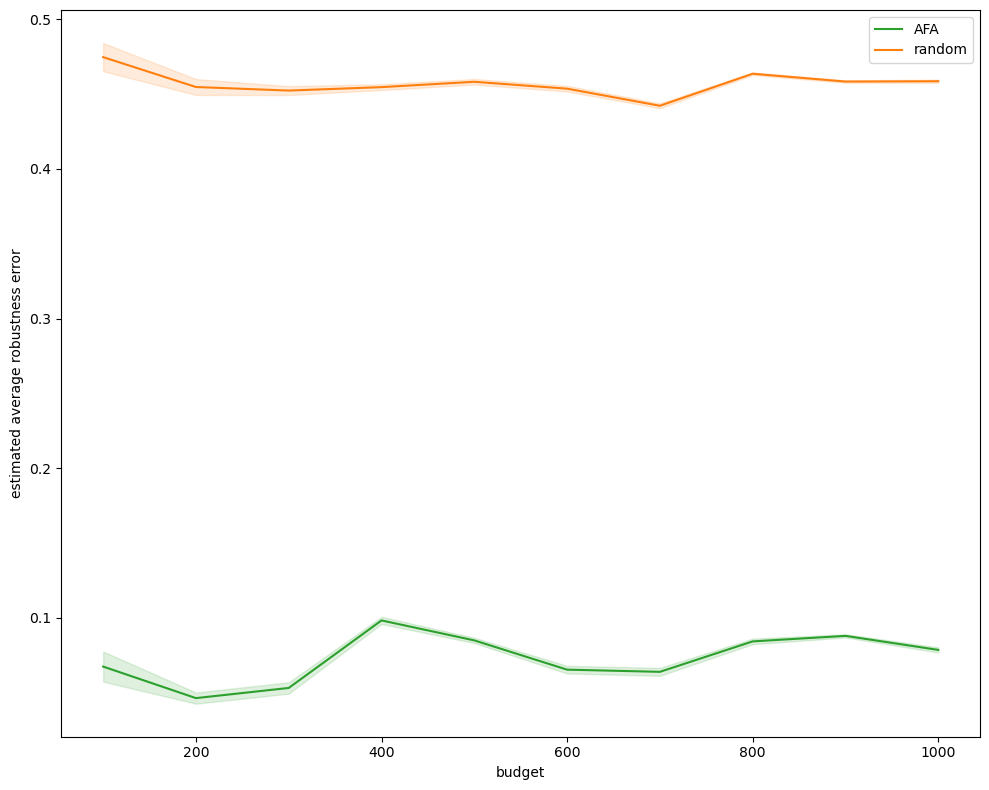

In [141]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

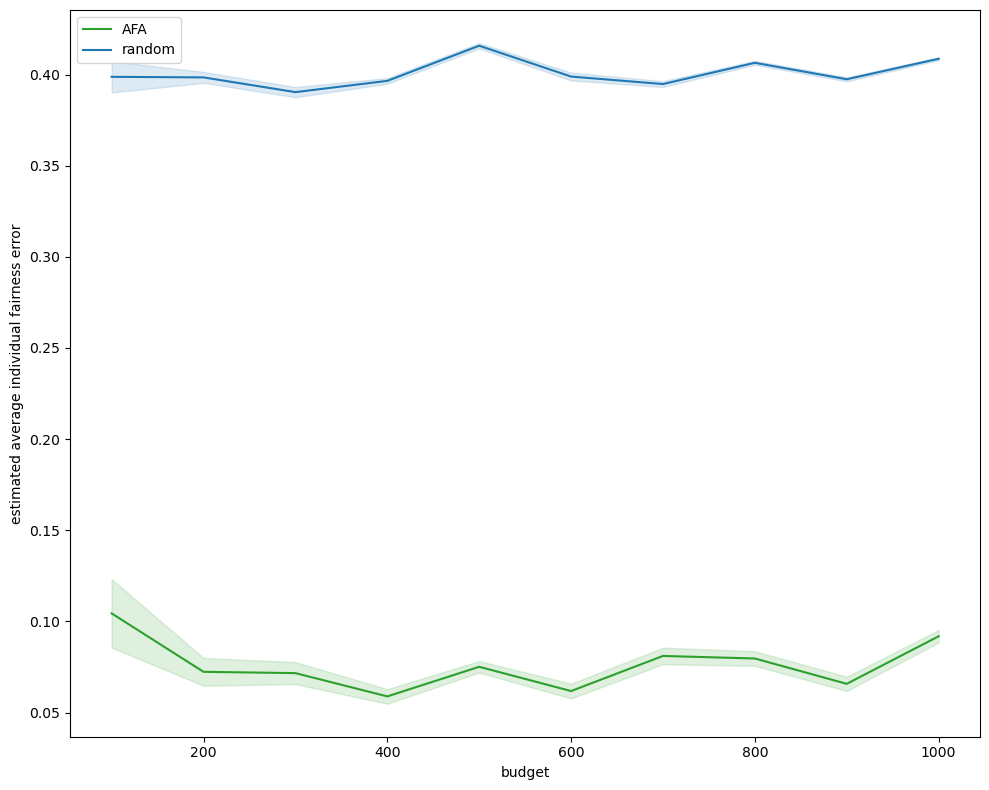

In [142]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 2

In [143]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 2"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [144]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.1963707

In [145]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.25081012

In [146]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [147]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [148]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [149]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [150]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [151]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [152]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [153]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [154]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.235243,0.091433,0.080200,0.254700,0.396400
2,10.0,0.335094,0.091218,0.226352,0.330286,0.488148
3,10.0,0.275674,0.085424,0.149890,0.300989,0.396998
4,10.0,0.308988,0.068239,0.177371,0.306461,0.403837
5,10.0,0.310854,0.066897,0.216750,0.304029,0.423869
6,10.0,0.279021,0.035961,0.216433,0.277213,0.360400
7,10.0,0.293162,0.065892,0.217935,0.275832,0.425574
8,10.0,0.308008,0.048413,0.211522,0.305029,0.383874
9,10.0,0.282211,0.049472,0.183204,0.303953,0.329092


In [155]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.240261,0.085488,0.112593,0.241401,0.393918
2,10.0,0.250830,0.054340,0.143640,0.257247,0.315989
3,10.0,0.295941,0.063359,0.160040,0.301027,0.373613
4,10.0,0.284311,0.051333,0.202148,0.279775,0.365500
5,10.0,0.265641,0.046531,0.179177,0.275086,0.325353
6,10.0,0.272893,0.027378,0.238722,0.274697,0.323433
7,10.0,0.291521,0.032453,0.252503,0.295956,0.339633
8,10.0,0.271115,0.026504,0.226496,0.274821,0.304980
9,10.0,0.289823,0.027420,0.246171,0.294722,0.320999


In [156]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.490758, 0.4707935, 0.46841335, 0.47071156, 0.474288, 0.46968585, 0.45826548, 0.47965923, 0.47443947, 0.4746582]
random estimator average error for individual fairness: [0.38582352, 0.38550833, 0.37742907, 0.38360384, 0.40288252, 0.38596192, 0.38185748, 0.39350948, 0.384484, 0.3957433]
AFA average error for robustness: [0.0715273238075638, 0.06717920343269133, 0.10683700992855512, 0.0879402327153189, 0.07270927893805512, 0.07652255756115224, 0.095150280472776, 0.07474442550659388, 0.09345254005781889, 0.0908370484658789]
AFA average error for individual fairness: [0.07049434710000002, 0.0936487158882141, 0.07851613305488077, 0.07420255135109613, 0.06828188438232118, 0.03508633110809491, 0.053462301414564053, 0.06505601027642822, 0.05201183090454338, 0.0877084957705353]


In [157]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

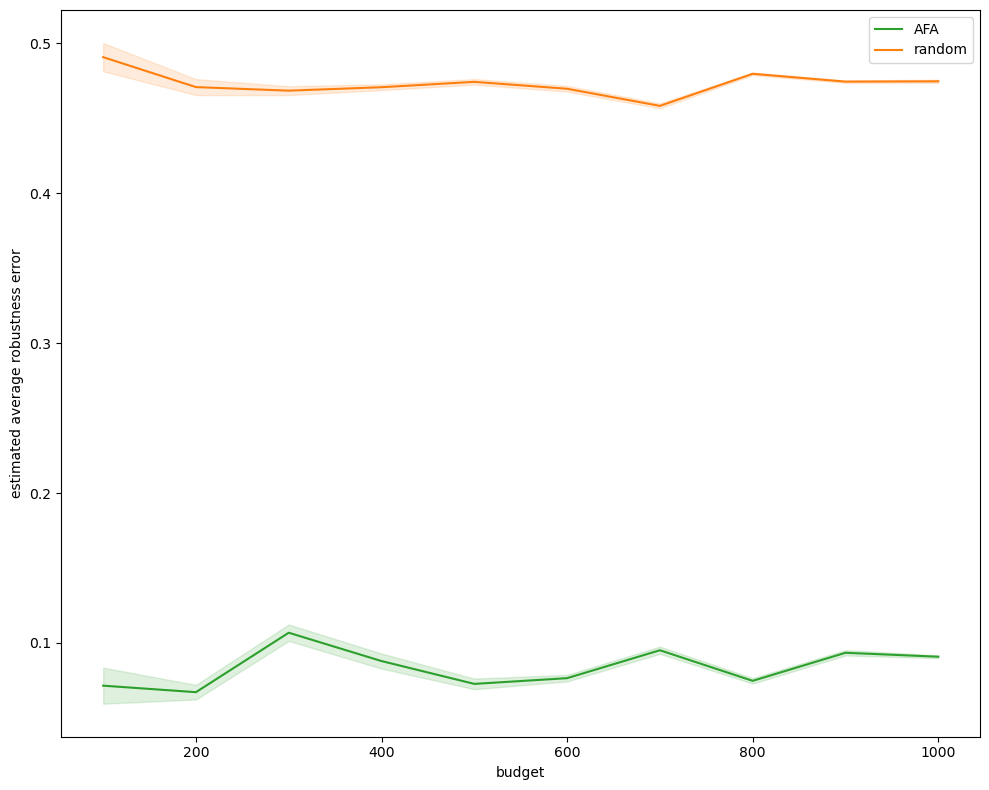

In [158]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

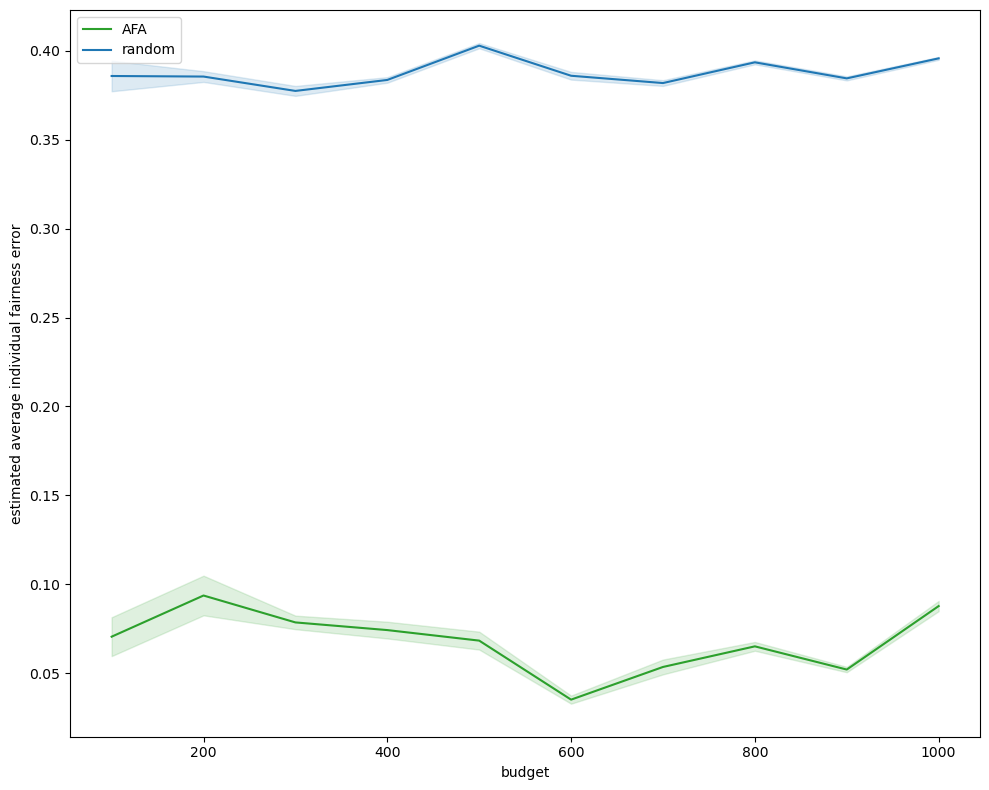

In [159]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 3

In [160]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 3"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [161]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.20674011

In [162]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.32047957

In [163]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [164]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [165]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [166]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [167]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [168]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [169]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [170]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [171]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.208768,0.084544,0.122713,0.184558,0.327500
2,10.0,0.262547,0.055611,0.175901,0.265486,0.328152
3,10.0,0.268516,0.049373,0.212352,0.262439,0.374438
4,10.0,0.288842,0.055501,0.216533,0.281948,0.394793
5,10.0,0.309873,0.060286,0.231034,0.305715,0.434114
6,10.0,0.280587,0.076760,0.199310,0.261676,0.421186
7,10.0,0.281061,0.027509,0.228086,0.283049,0.319381
8,10.0,0.296417,0.040214,0.203766,0.310869,0.340717
9,10.0,0.310267,0.041641,0.229726,0.321178,0.378522


In [172]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.291611,0.073308,0.202736,0.273834,0.397070
2,10.0,0.281282,0.061235,0.203262,0.271419,0.368664
3,10.0,0.270892,0.062033,0.166443,0.270288,0.356794
4,10.0,0.293721,0.032445,0.266127,0.280201,0.370719
5,10.0,0.302377,0.045677,0.229286,0.300028,0.388738
6,10.0,0.279998,0.043549,0.208149,0.280494,0.369133
7,10.0,0.274967,0.034742,0.214264,0.276624,0.338262
8,10.0,0.299178,0.046672,0.237011,0.300659,0.387519
9,10.0,0.299337,0.034684,0.252630,0.306687,0.354866


In [173]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.48038855, 0.4604241, 0.45804396, 0.46034217, 0.46391854, 0.45931643, 0.44789615, 0.46928987, 0.46407008, 0.46428886]
random estimator average error for individual fairness: [0.3161541, 0.31583884, 0.3077596, 0.3139344, 0.33321303, 0.31629246, 0.31218806, 0.32384, 0.31481454, 0.32607388]
AFA average error for robustness: [0.08634971933244323, 0.07523734107692431, 0.07574441127910989, 0.08698107913755534, 0.09563718813620534, 0.0732577932074054, 0.06822640740479112, 0.09243817203370537, 0.09259696235540539, 0.0917114011576154]
AFA average error for individual fairness: [0.11311539805544432, 0.05946704970544434, 0.06275503371251102, 0.05272604523933322, 0.045757127347800006, 0.07928889097491662, 0.0394184064464483, 0.03035017606647216, 0.026296808362805568, 0.028095603411861063]


In [174]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

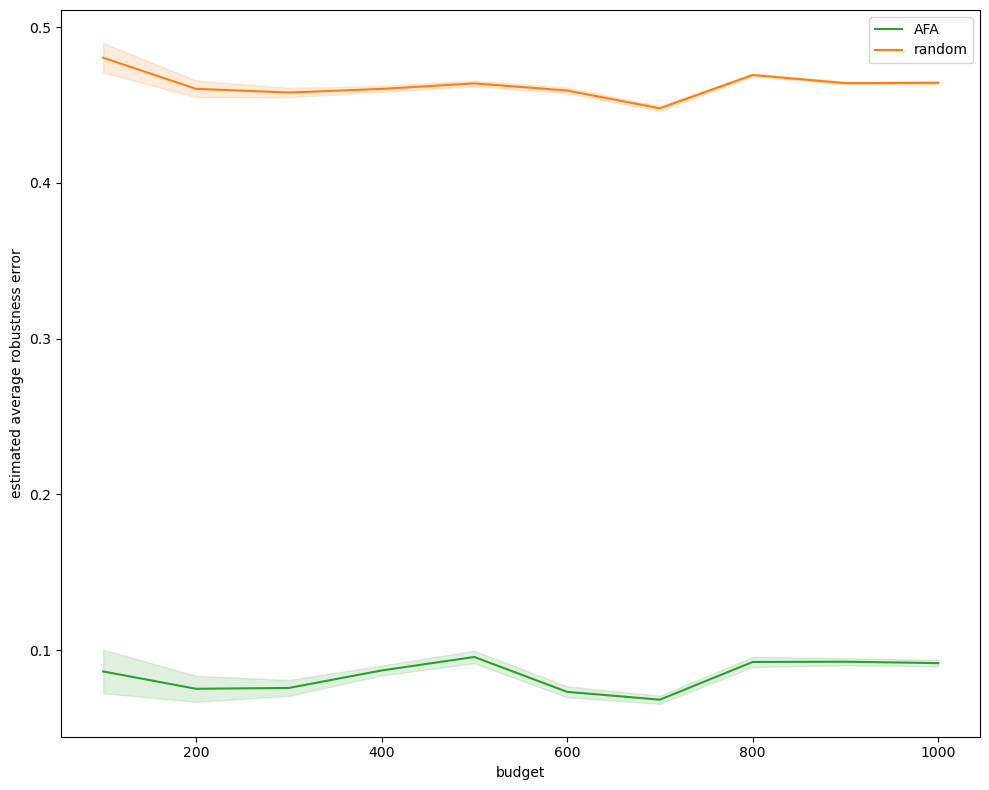

In [175]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

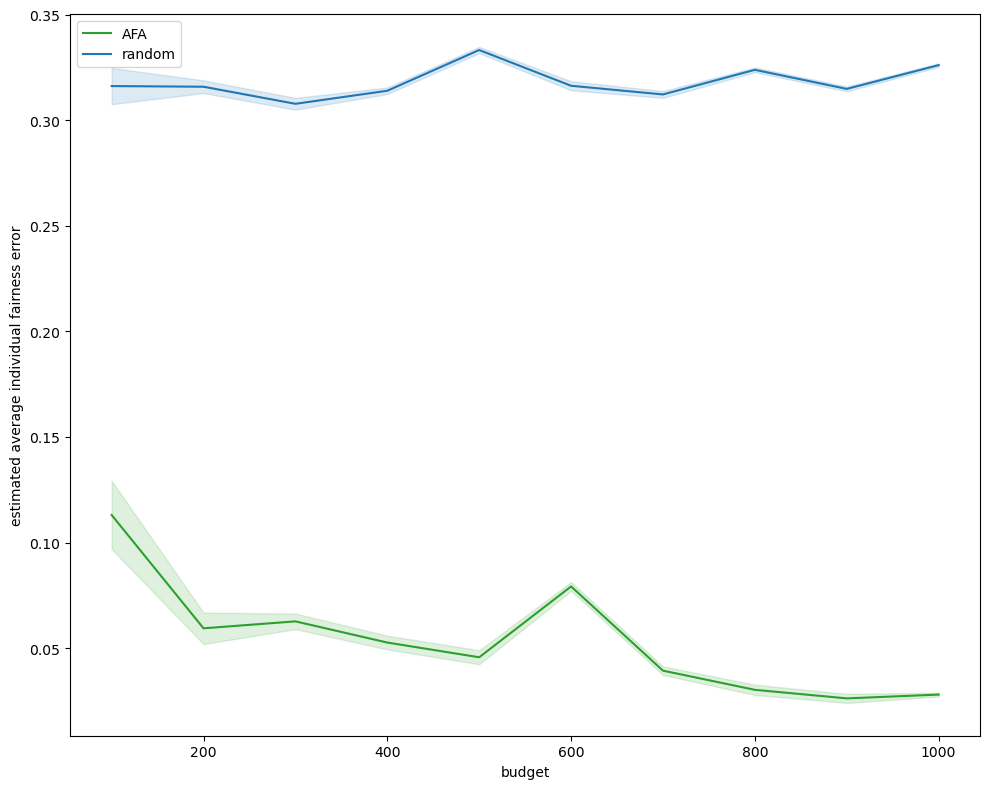

In [176]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 4

In [177]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 4"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [178]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.20576799

In [179]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.28532082

In [180]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [181]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [182]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [183]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [184]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)
 
for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/258747296.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/258747296.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/258747296.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

In [185]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [186]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [187]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [188]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.257366,0.109724,0.132320,0.264645,0.395353
2,10.0,0.245244,0.098101,0.042338,0.261951,0.413696
3,10.0,0.278095,0.044147,0.207543,0.265881,0.337659
4,10.0,0.299179,0.074750,0.167124,0.302834,0.408300
5,10.0,0.301599,0.068470,0.194016,0.293924,0.410654
6,10.0,0.269300,0.053566,0.180884,0.262810,0.363238
7,10.0,0.295372,0.039487,0.226624,0.310184,0.338850
8,10.0,0.285106,0.031760,0.236086,0.279318,0.339350
9,10.0,0.327943,0.076590,0.157431,0.334033,0.460625


In [189]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.230645,0.041860,0.190017,0.217196,0.316067
2,10.0,0.233929,0.074788,0.099673,0.232870,0.373052
3,10.0,0.257365,0.063635,0.128335,0.274484,0.356730
4,10.0,0.263732,0.043432,0.183243,0.265517,0.311298
5,10.0,0.285498,0.045311,0.215299,0.278180,0.353088
6,10.0,0.298656,0.046316,0.234171,0.300599,0.370657
7,10.0,0.280886,0.031587,0.225255,0.280610,0.342493
8,10.0,0.304153,0.039121,0.242849,0.303295,0.365221
9,10.0,0.295523,0.033127,0.238661,0.302388,0.358100


In [190]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.48136073, 0.46139622, 0.45901603, 0.4613143, 0.46489072, 0.46028858, 0.44886827, 0.470262, 0.46504226, 0.46526098]
random estimator average error for individual fairness: [0.35131285, 0.3509976, 0.34291837, 0.34909314, 0.36837178, 0.35145122, 0.34734678, 0.35899878, 0.3499733, 0.3612326]
AFA average error for robustness: [0.032701710768273905, 0.05830958826460285, 0.06893256760148843, 0.06246863046922071, 0.0797302161791896, 0.09288850873725296, 0.07511813212649818, 0.09838533819311959, 0.0897552181723363, 0.09271929680836966]
AFA average error for individual fairness: [0.09870008150000001, 0.07258394235468993, 0.03907210135151164, 0.060243771815155035, 0.055063104365710026, 0.04446113231620159, 0.03510293548427359, 0.02539847904734499, 0.06819999287506456, 0.03218622827000005]


In [191]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

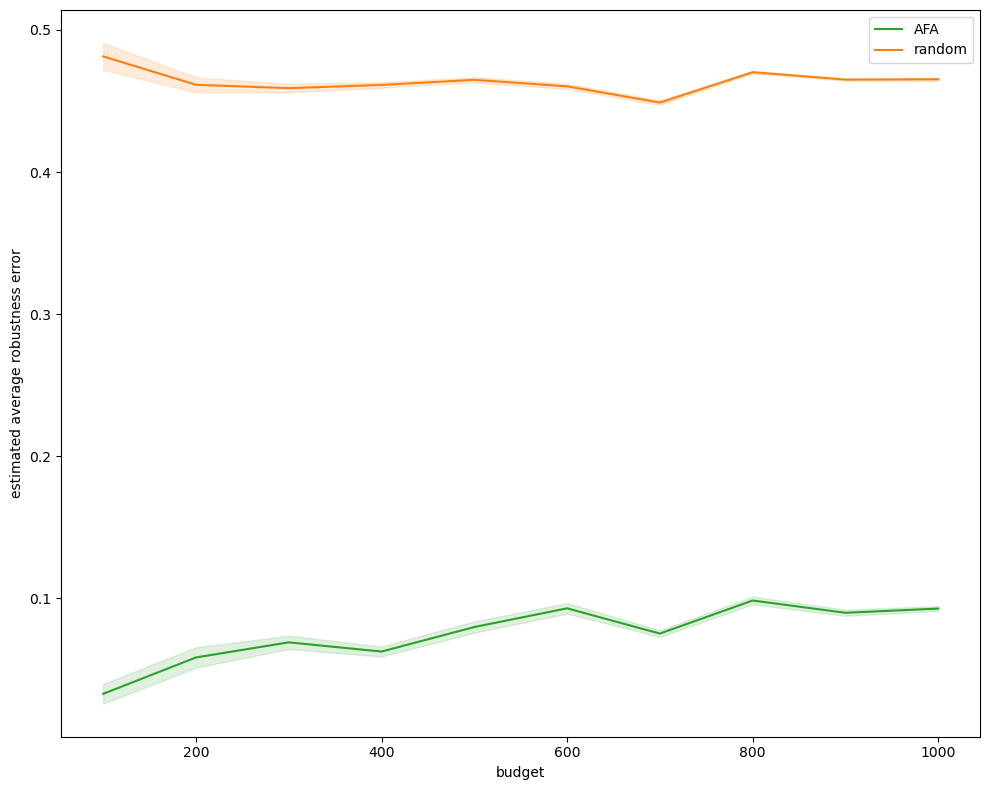

In [192]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

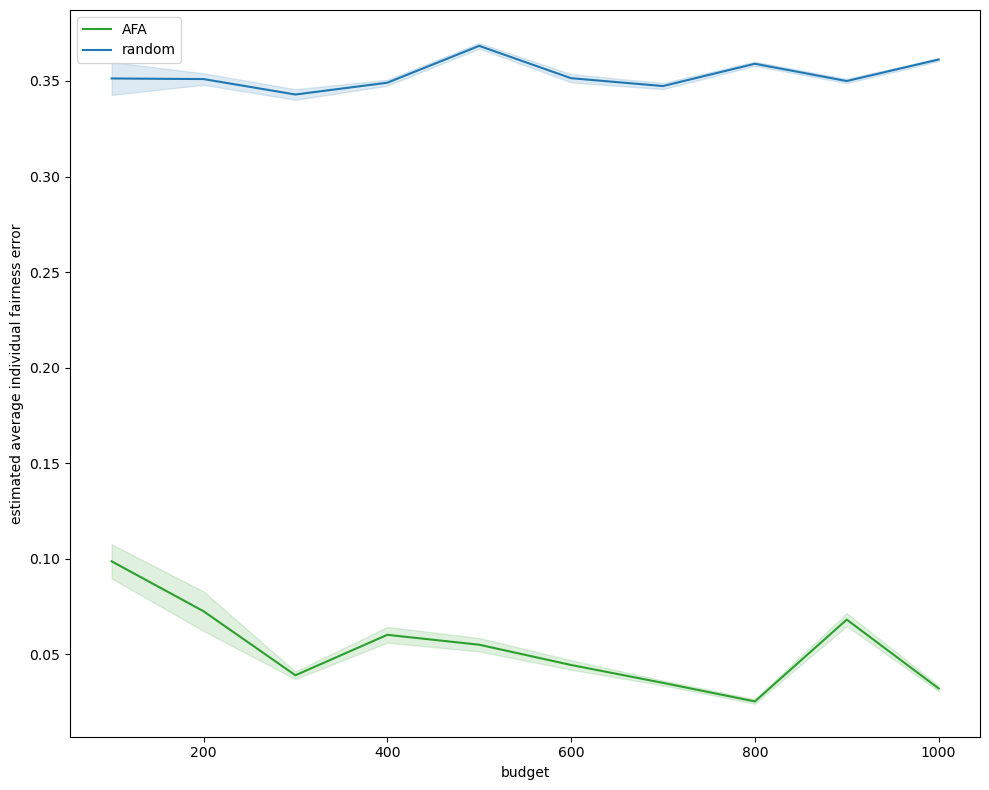

In [193]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 5

In [194]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 5"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [195]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.37540504

In [196]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.40537915

In [197]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights



def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))
    

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [198]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [199]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [200]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [201]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [202]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [203]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [204]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [205]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.267728,0.067425,0.180733,0.273000,0.426724
2,10.0,0.225809,0.050666,0.156817,0.210142,0.310260
3,10.0,0.263456,0.044081,0.185739,0.255734,0.337493
4,10.0,0.245450,0.038575,0.194981,0.236382,0.325091
5,10.0,0.256373,0.042531,0.217105,0.234573,0.344084
6,10.0,0.251306,0.045660,0.186397,0.242524,0.316535
7,10.0,0.249879,0.034528,0.207104,0.245095,0.326855
8,10.0,0.253374,0.039851,0.214932,0.241714,0.344625
9,10.0,0.261847,0.034574,0.213377,0.253802,0.331925


In [206]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.225356,0.056285,0.155350,0.215844,0.323703
2,10.0,0.210715,0.030116,0.169081,0.207030,0.255249
3,10.0,0.242734,0.029033,0.196216,0.250201,0.283707
4,10.0,0.218734,0.025339,0.184415,0.210978,0.270335
5,10.0,0.235997,0.017067,0.211068,0.235449,0.263476
6,10.0,0.234343,0.026669,0.193704,0.240778,0.269777
7,10.0,0.237945,0.016128,0.217408,0.234808,0.265637
8,10.0,0.233875,0.013733,0.209666,0.234150,0.254012
9,10.0,0.238035,0.021769,0.204626,0.236525,0.280122


In [207]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.31172365, 0.29175913, 0.289379, 0.29167727, 0.29525366, 0.29065153, 0.27923122, 0.3006249, 0.29540518, 0.29562396]
random estimator average error for individual fairness: [0.2312545, 0.23093927, 0.22286005, 0.22903481, 0.24831347, 0.23139289, 0.22728845, 0.23894045, 0.22991498, 0.2411743]
AFA average error for robustness: [0.15004931496357118, 0.16469008012757116, 0.1326710104202378, 0.15667142318382118, 0.13940782338855118, 0.1410623398787378, 0.13746017820728545, 0.14152995504044613, 0.13737007934201223, 0.13943098484117117]
AFA average error for individual fairness: [0.14192053767000734, 0.17957016512665916, 0.1419230176750928, 0.15992963211848416, 0.1490064377985092, 0.15407290183000913, 0.15550061932322343, 0.15200564514838805, 0.14353174490004245, 0.14088300845962115]


In [208]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

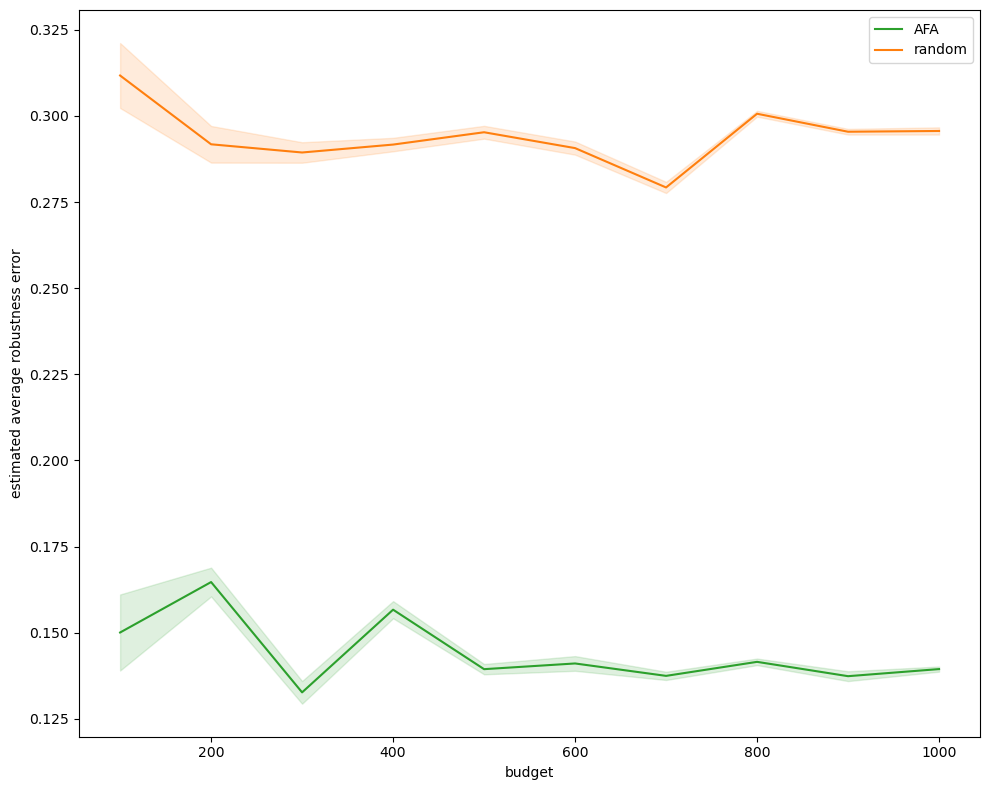

In [209]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

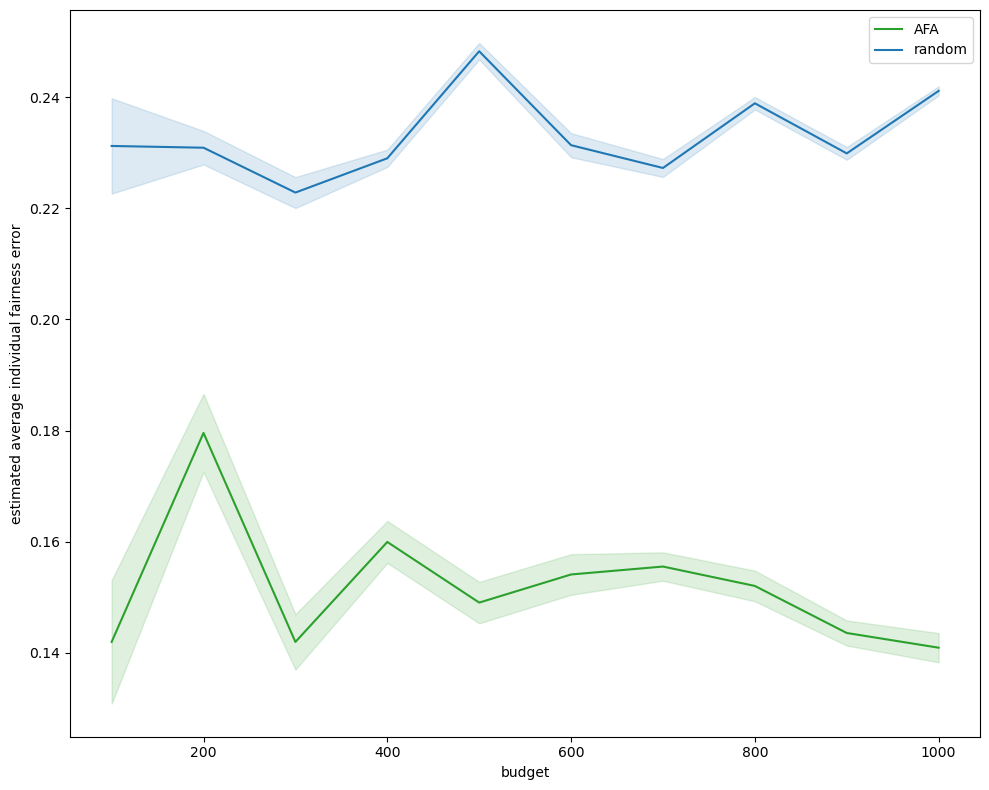

In [210]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

## Experiment 6

In [211]:
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)
constants = config.get('constants', {})
n = constants.get('n')
teta = constants.get('teta')
numpy_seed = constants.get('numpy_seed')
experiment_dict = {experiment['name']: experiment for experiment in config['experiments for l']}
target_experiment_name = "Experiment 6"
target_experiment = experiment_dict.get(target_experiment_name)

if target_experiment:
    # Retrieve parameters of the target experiment
    target_parameters = target_experiment.get('parameters')
    rho = target_parameters['rho']
    l = target_parameters['l']

p = (1 + rho) / 2

def first_perturbation_protocol(x, rho):
    xp = np.zeros(n)
    for i in range(n): 
        if rng.binomial(1, p) == 1:  # defines first perturbation protocol
            xp[i] = x[i]
        else:
            xp[i] = -x[i] 
    return xp

def second_perturbation_protocol(x, rho, l):
    xp = np.zeros(n)
    coord_var = rng.choice(range(n), size=l, replace=False)
    for i in range(n):
        if i in coord_var:
            if rng.binomial(1, p) == 1:
                xp[i] = x[i]
            else:
                xp[i] = -x[i]
    return xp



In [212]:
def evaluate_rb(h,S,rho):
    hX = h.predict(S)
    Xp = np.array([first_perturbation_protocol(x, rho) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32)))

true_rb = evaluate_rb(h_star,X,rho)
true_rb

0.36746597

In [213]:
def evaluate_if(h, S,rho,l):
    hX = h.predict(S)
    Xp = np.array([second_perturbation_protocol(x, rho, l) for x in S])
    hXp = h.predict(Xp)
    return np.average(np.absolute(hX.astype(np.float32) - hXp.astype(np.float32))) 

true_if = evaluate_if(h_star, X,rho,l)
true_if

0.42887232

In [214]:
#baseline
def iid_rb(label_budget,rho, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([first_perturbation_protocol(x, rho) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32)))

def iid_if(label_budget,rho,l, model = h_star):
    Sx = np.array([random_input_generator(n) for _ in range(label_budget + 1)])
    hX = model.predict(Sx)
    Y = np.array([second_perturbation_protocol(x, rho, l) for x in Sx])
    hY = model.predict(Y)
    return np.average(np.absolute(hX.astype(np.float32) - hY.astype(np.float32))) 

#ours 
class Black_Box:
    def __init__(self, n):
        self.input_length = n
    def eval(self, x):
        return h_star.predict(x.reshape(1, -1))

# Find monomials
def find_monomials(label_budget, model = Black_Box(n)):
    gl = streaming_goldreich.GoldreichLevin(model, teta, label_budget)
    return gl.find_heavy_monomials() # A list of tuples of subsets and their weights


def char(property, rho, monomial, lx = l):
    #characteristic function of the property
    if property == "rb":
        return rho** np.sum(monomial)
    elif property == "if":
        return rho**(np.sum(np.absolute(np.array(monomial).astype(np.float32) - second_perturbation_protocol(monomial, rho, lx).astype(np.float32))))

def property_estimator(property, label_budget, rho, l, model = Black_Box(n)):
    monomials = find_monomials(label_budget, model)
    estimate = 0.0
    for monomial in monomials:
        estimate += char(property, rho, monomial[0],l) * monomial[1]
    return estimate



In [215]:
#ours
AFA_experiments = [dict([(k, []) for k in range(n_iterations)]) for _ in range(10)]    
for idx,experiment in enumerate(AFA_experiments):
    for i in range(n_iterations):
        experiment[i].append([property_estimator("rb", (idx+1)*100,rho,l), property_estimator("if", (idx+1)*100,rho,l)])

In [216]:
AFA_df = pd.DataFrame(AFA_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
AFA_df = AFA_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        AFA_df[robust_column] = AFA_df[i][j][0][0]
        AFA_df[if_column] = AFA_df[i][j][0][1]
AFA_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[if_column] = AFA_df[i][j][0][1]
/tmp/ipykernel_321403/4099473552.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AFA_df[robust_column] = AFA_df[i][j][0][0]
/tmp/ipykernel_321403/4099473552.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [217]:
IID_df = pd.DataFrame(IID_experiments)
dictio = {i: f"experiment_{i+1}" for i in range(10)}
IID_df = IID_df.rename(index = dictio)

for i in range(n_iterations):
    for j in range(10):
        robust_column = "Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1) 
        if_column = "Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)
        IID_df[robust_column] = IID_df[i][j][0][0]
        IID_df[if_column] = IID_df[i][j][0][1]

IID_df.drop([i for i in range(n_iterations)], axis = 1, inplace = True)

/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[if_column] = IID_df[i][j][0][1]
/tmp/ipykernel_321403/1722599108.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IID_df[robust_column] = IID_df[i][j][0][0]
/tmp/ipykernel_321403/1722599108.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented f

In [218]:
#Robustness experiments with IID summary:
IID_table_RB = [[i+1,j+1,IID_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_RB_experiments = pd.DataFrame(IID_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
IID_RB_experiments["error"] = abs(IID_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with IID summary:
IID_table_IF = [[i+1,j+1,IID_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
IID_IF_experiments = pd.DataFrame(IID_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
IID_IF_experiments["error"] = abs(IID_IF_experiments["Estimated_IF"] - true_if)

#Robustness experiments with AFA summary:
AFA_table_RB = [[i+1,j+1,AFA_df["Robustness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_RB_experiments = pd.DataFrame(AFA_table_RB, columns=['Iteration','Experiment','Estimated_Robustness'])
AFA_RB_experiments["error"] = abs(AFA_RB_experiments["Estimated_Robustness"] - true_rb)
#Individual fairness experiments with AFA summary:
AFA_table_IF = [[i+1,j+1,AFA_df["Individual_Fairness_iteration_" + str(i+1) + "_experiment_" + str(j+1)][j]] for i in range(n_iterations) for j in range(10)]
AFA_IF_experiments = pd.DataFrame(AFA_table_IF, columns=['Iteration','Experiment','Estimated_IF'])
AFA_IF_experiments["error"] = abs(AFA_IF_experiments["Estimated_IF"] - true_if)

In [219]:
IID_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.636634,0.043796,0.544554,0.648515,0.693069
2,10.0,0.636318,0.021806,0.606965,0.631841,0.681592
3,10.0,0.628239,0.024636,0.584718,0.632890,0.671096
4,10.0,0.634414,0.015912,0.618454,0.630923,0.668329
5,10.0,0.653693,0.016891,0.632735,0.646707,0.690619
6,10.0,0.636772,0.027115,0.575707,0.643095,0.665557
7,10.0,0.632668,0.021762,0.600571,0.633381,0.667618
8,10.0,0.644320,0.016240,0.617977,0.643571,0.670412
9,10.0,0.635294,0.017581,0.604883,0.640954,0.653718


In [220]:
IID_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.687129,0.048099,0.594059,0.688119,0.752475
2,10.0,0.667164,0.038355,0.616915,0.656716,0.731343
3,10.0,0.664784,0.026274,0.614618,0.667774,0.714286
4,10.0,0.667082,0.019959,0.643392,0.664589,0.708229
5,10.0,0.670659,0.021207,0.638723,0.672655,0.696607
6,10.0,0.666057,0.023805,0.625624,0.668053,0.700499
7,10.0,0.654636,0.021899,0.626248,0.653352,0.690442
8,10.0,0.676030,0.012150,0.656679,0.680400,0.689139
9,10.0,0.670810,0.012570,0.648169,0.669811,0.690344


In [221]:
AFA_IF_experiments.groupby(["Experiment"])["Estimated_IF"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.242453,0.044447,0.172300,0.248194,0.320700
2,10.0,0.230372,0.015530,0.204000,0.234746,0.249360
3,10.0,0.239030,0.012815,0.224920,0.235730,0.260013
4,10.0,0.244752,0.025546,0.213791,0.244485,0.294559
5,10.0,0.255444,0.045417,0.186626,0.249874,0.332533
6,10.0,0.255282,0.027947,0.220780,0.247792,0.299066
7,10.0,0.248981,0.017012,0.229386,0.243997,0.281638
8,10.0,0.241521,0.032408,0.209232,0.234835,0.313000
9,10.0,0.250549,0.034229,0.211160,0.243411,0.305298


In [222]:
AFA_RB_experiments.groupby(["Experiment"])["Estimated_Robustness"].describe(percentiles=[])

,count,mean,std,min,50%,max
Experiment,,,,,,
1,10.0,0.206335,0.042337,0.159854,0.204057,0.266693
2,10.0,0.235656,0.029394,0.192046,0.233871,0.276430
3,10.0,0.224404,0.031155,0.162693,0.229402,0.263731
4,10.0,0.230106,0.024956,0.175451,0.237050,0.258952
5,10.0,0.237844,0.013407,0.221047,0.235441,0.258015
6,10.0,0.231439,0.031604,0.195873,0.226755,0.287822
7,10.0,0.238511,0.011664,0.215072,0.239755,0.254708
8,10.0,0.238477,0.015246,0.209181,0.238049,0.257882
9,10.0,0.247177,0.015007,0.229711,0.243417,0.281280


In [223]:
IID_Mean_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for robustness:",IID_Mean_RB)
IID_Mean_IF =[IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("random estimator average error for individual fairness:",IID_Mean_IF)
IID_std_RB = [IID_RB_experiments[IID_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
IID_std_IF = [IID_IF_experiments[IID_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]


AFA_Mean_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for robustness:",AFA_Mean_RB)
AFA_Mean_IF =[AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].mean() for i in range(10)]
print("AFA average error for individual fairness:",AFA_Mean_IF)
AFA_std_RB = [AFA_RB_experiments[AFA_RB_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]
AFA_std_IF = [AFA_IF_experiments[AFA_IF_experiments["Experiment"] == i+1]["error"].std() for i in range(10)]

random estimator average error for robustness: [0.31966275, 0.29969823, 0.29731807, 0.29961634, 0.30319273, 0.2985906, 0.28717026, 0.308564, 0.30334425, 0.303563]
random estimator average error for individual fairness: [0.20776133, 0.2074461, 0.19936688, 0.20554164, 0.2248203, 0.20789972, 0.20379528, 0.21544728, 0.2064218, 0.21768112]
AFA average error for robustness: [0.16113106322339063, 0.13181037787789063, 0.1430623785143906, 0.1373603197620656, 0.12962157293027066, 0.13602696289957397, 0.12895451097871918, 0.12898899944089065, 0.12028857775383509, 0.13240674418943063]
AFA average error for individual fairness: [0.18641922794572938, 0.19850038110872936, 0.18984210643239602, 0.18412022997024433, 0.17342804824312938, 0.17358986292939602, 0.1798912469575708, 0.18735090669039184, 0.178322856099696, 0.17079488408796836]


In [224]:
IID_lower_CI_RB = [IID_Mean_RB[i] - 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_RB = [IID_Mean_RB[i] + 1.96* IID_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

IID_lower_CI_IF = [IID_Mean_IF[i] - 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
IID_upper_CI_IF = [IID_Mean_IF[i] + 1.96* IID_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]



AFA_lower_CI_RB = [AFA_Mean_RB[i] - 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_RB = [AFA_Mean_RB[i] + 1.96* AFA_std_RB[i]/math.sqrt(100*(i+1)) for i in range(10)]

AFA_lower_CI_IF = [AFA_Mean_IF[i] - 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]
AFA_upper_CI_IF = [AFA_Mean_IF[i] + 1.96* AFA_std_IF[i]/math.sqrt(100*(i+1)) for i in range(10)]

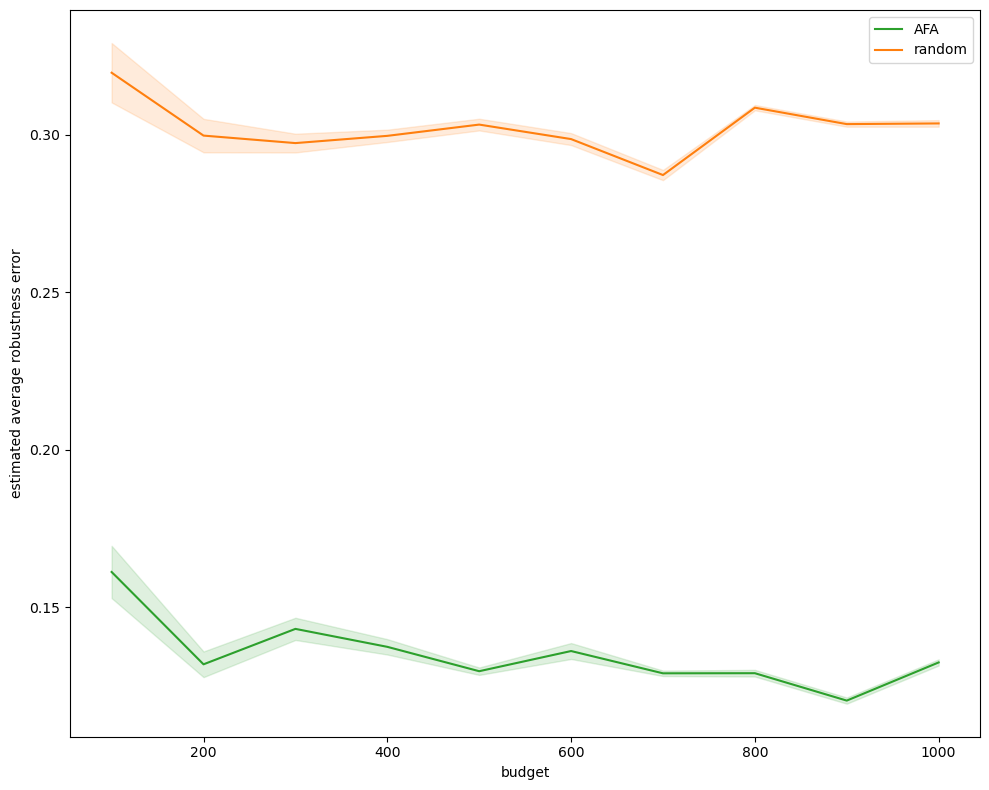

In [225]:
budgets = [100, 200, 300, 400, 500,600,700,800,900,1000]


plt.figure()
plt.plot(budgets, AFA_Mean_RB, color = 'C2', label="AFA")
plt.fill_between(budgets,AFA_lower_CI_RB, AFA_upper_CI_RB, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_RB, color = 'C1',label="random")
plt.fill_between(budgets,IID_lower_CI_RB, IID_upper_CI_RB, color = 'C1', alpha =.15)


plt.legend()
plt.ylabel("estimated average robustness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()

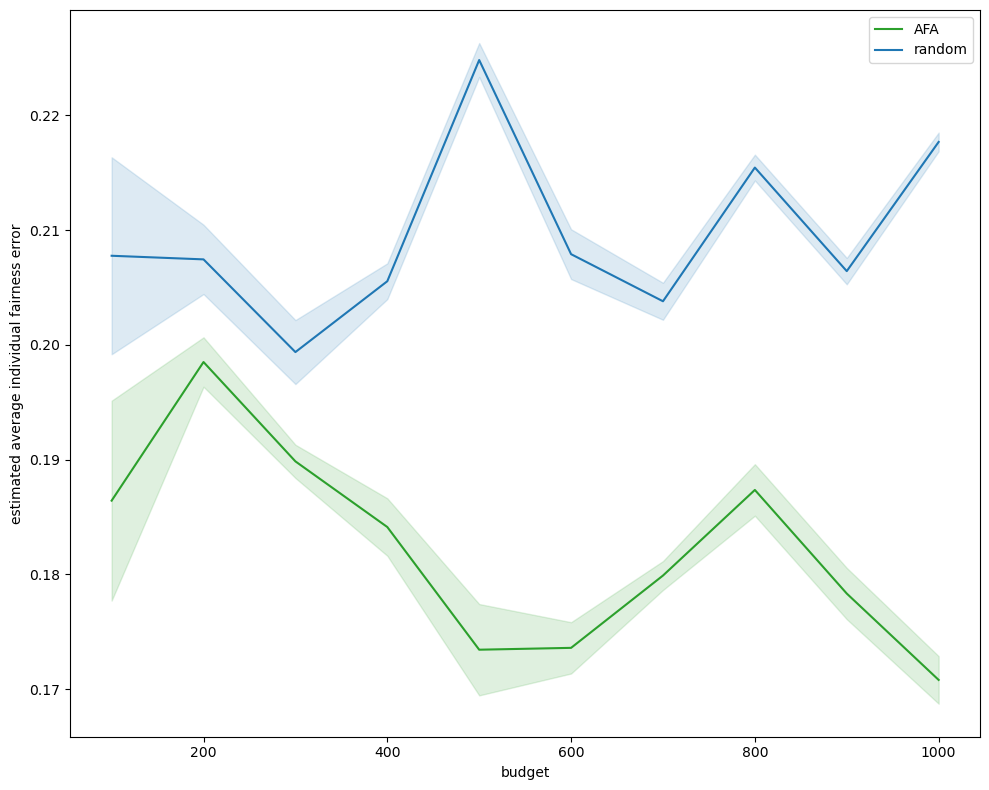

In [226]:
plt.figure()
plt.plot(budgets, AFA_Mean_IF, color = 'C2',label="AFA")
plt.fill_between(budgets,AFA_lower_CI_IF, AFA_upper_CI_IF, color = 'C2', alpha =.15)

plt.plot(budgets, IID_Mean_IF, color = 'C0',label="random")
plt.fill_between(budgets,IID_lower_CI_IF, IID_upper_CI_IF, color = 'C0', alpha =.15)


plt.legend()
plt.ylabel("estimated average individual fairness error")
plt.xlabel("budget")
plt.tight_layout()
plt.show()